<a href="https://colab.research.google.com/github/austinryan11/Applied-Deep-Learning/blob/master/Machine_Vision_with_NFL_Tracking_Data_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Vision with NFL Player Tracking Data**
*   BAIS:9010:0EXA Applied Deep Learning
*   Individual Deep Learning Project
*   Austin Ryan
*   July 26th, 2021

## **Project Goal**
My goal at the time of the project checkpoint was to utilize the NFL's Next Gen Stats data to build convolutional neural network (CNN) to predict the likelihood each receiver will be the quarterback's intended target at the time of the throw.

My knowledge of python is not much more than beginner level and prior to this project I had very little experience with higher-dimensional data. I preprocessed data into the shape of (24,427, 6, 7, 10) where 24,427 is the number of plays, and each play has 6 offensive players, 7 defensive players, and 10 features. I was unable to figure out how to construct the correct softmax output layer and shape of the target label (the targeted receiver for each play) for the original project goal. 

Given the time constraints and unresolved programming challenges I have adapted the goal to "Utilize the NFL's Next Gen Stats data to predict the likelihood a pass will be completed at the time of the throw". Constructing a binary classifer is less complex and better suited for my current skillset while still allowing me the opportunity to work on reshaping the raw tabular Next Gen Stats data into a tensor for an image recognition problem.


## **Data Primer**
Over the last half decade the NFL has placed RFID tags in players' shoulder pads and the football during live games. These tags capture data about the player's location, speed, and acceleration 10 times per second. See more at https://operations.nfl.com/gameday/technology/nfl-next-gen-stats/. 

Since 2018 the NFL has hosted a competition (the Big Data Bowl) where some of the tracking data is released to the public to spur innovation and insights in football analytics. The data for my project is from the 2021 Big Data Bowl and can be found here https://www.kaggle.com/c/nfl-big-data-bowl-2021/data.

The approach of treating player tracking data as an image recognition has shown success in the 2019 and 2020 versions of the Big Data Bowl. In [2019](https://operations.nfl.com/media/3671/big-data-bowl-sterken.pdf) a winning entry used a CNN to classify the best receiver-route combinations and in [2020](https://www.kaggle.com/c/nfl-big-data-bowl-2020/discussion/119400) a CNN had great success predicting how many rushing yards would be earned on a given play.


## **Data Preprocessing**

In [1]:
# Mount my google drive so csvs can be accessed from the colab environment.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import dependencies
import pandas as pd
import numpy as np
import os
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import Image
import tensorflow as tf
from tensorflow.keras.models import (Sequential, Model)
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Lambda, Conv1D, LayerNormalization, AvgPool2D, AvgPool1D, MaxPooling1D, Input, Add)
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.metrics import roc_auc_score

# Install pyjanitor. I have an unhealthy hatred for columns with random spaces and capitalization
!pip install pyjanitor --quiet
import janitor

     |████████████████████████████████| 99 kB 3.9 MB/s 


In [3]:
# read in weeks 1 - 17 of tracking data

# create empty list
df_tracking = list()

# loop through weeks 1 - 17 csvs and append to df_tracking list
for week in range(1, 18):
  df_week = pd.read_csv('drive/MyDrive/BDB_2021/week' + str(week) + '.csv').clean_names()
  df_tracking.append(df_week)
  # get rid of temporary df_week object
  del df_week

# create pandas dataframe for all weeks of data
df_tracking = pd.concat(df_tracking)

# get rid of columns I'm not going to use
del df_tracking['time'] # datetime of when the frame occurred
del df_tracking['dis'] # distance each player ran on the play prior to the current frame
del df_tracking['route'] # type of route each receiver ran

# there is a row for the football in each play where the nflid and jersey number of the football is na. 
# fill nas with zero so we can convert nflid to integer
df_tracking['nflid'] = df_tracking['nflid'].fillna(0).astype('int')
df_tracking['jerseynumber'] = df_tracking['jerseynumber'].fillna(0).astype('int')

# see details of dataframe
df_tracking.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18309388 entries, 0 to 1049264
Data columns (total 16 columns):
 #   Column         Dtype  
---  ------         -----  
 0   x              float64
 1   y              float64
 2   s              float64
 3   a              float64
 4   o              float64
 5   dir            float64
 6   event          object 
 7   nflid          int64  
 8   displayname    object 
 9   jerseynumber   int64  
 10  position       object 
 11  frameid        int64  
 12  team           object 
 13  gameid         int64  
 14  playid         int64  
 15  playdirection  object 
dtypes: float64(6), int64(5), object(5)
memory usage: 2.3+ GB


Raw data contains over 18 million rows and 15 columns and is using 2.3+ GB of memory. Colab has been crashing due to memory constaints when attempting to use all frames for each play. So I will filter each play down to the frame where the pass is being attempted. Doing so reduces the size of tracking data to 260,000 rows and 32 mb of memory.

In [4]:
# filter df_tracking to only contain frames where the pass is being attempted
df_tracking = df_tracking[df_tracking.event == 'pass_forward']
del df_tracking['event']
df_tracking.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260480 entries, 490 to 1048354
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   x              260480 non-null  float64
 1   y              260480 non-null  float64
 2   s              260480 non-null  float64
 3   a              260479 non-null  float64
 4   o              242698 non-null  float64
 5   dir            242699 non-null  float64
 6   nflid          260480 non-null  int64  
 7   displayname    260480 non-null  object 
 8   jerseynumber   260480 non-null  int64  
 9   position       242733 non-null  object 
 10  frameid        260480 non-null  int64  
 11  team           260480 non-null  object 
 12  gameid         260480 non-null  int64  
 13  playid         260480 non-null  int64  
 14  playdirection  260480 non-null  object 
dtypes: float64(6), int64(5), object(4)
memory usage: 31.8+ MB


In [5]:
# convert ids to strings
df_tracking['gameid'] = df_tracking['gameid'].astype('str')
df_tracking['playid'] = df_tracking['playid'].astype('str')
df_tracking['frameid'] = df_tracking['frameid'].astype('str')

# since we only have one frame per play this id is a little redundant. 
# I.e. frameid isn't really relevant in this project but will try to make a model for all frames 
# at a later time so I want to retain this element of the id.
df_tracking['id'] = df_tracking['gameid'] + df_tracking['playid'] + df_tracking['frameid']

In [6]:
# Number of unique plays
len(df_tracking.id.unique())

17794

In [7]:
# store an example play id
ex_play = df_tracking.id.iloc[0]

In [8]:
# take a peek at what the raw data from one frame where the pass is being attempted looks like
df_tracking[df_tracking.id == ex_play]

,x,y,s,a,o,dir,nflid,displayname,jerseynumber,position,frameid,team,gameid,playid,playdirection,id
490,96.43,26.78,0.84,2.05,356.40,333.39,310,Matt Ryan,2,QB,36,away,2018090600,75,left,20180906007536
491,84.82,38.33,5.53,4.30,295.34,318.58,79848,Malcolm Jenkins,27,SS,36,home,2018090600,75,left,20180906007536
492,80.69,44.91,3.11,6.67,155.11,297.88,2495454,Julio Jones,11,WR,36,away,2018090600,75,left,20180906007536
493,86.02,18.64,3.52,0.69,28.19,216.15,2495613,Corey Graham,24,FS,36,home,2018090600,75,left,20180906007536
494,82.65,34.56,6.35,1.21,262.06,272.78,2533040,Mohamed Sanu,12,WR,36,away,2018090600,75,left,20180906007536
495,69.63,30.81,2.93,2.65,79.24,315.98,2534832,Rodney McLeod,23,FS,36,home,2018090600,75,left,20180906007536
496,93.81,27.30,3.92,3.23,293.03,332.35,2543583,Devonta Freeman,24,RB,36,away,2018090600,75,left,20180906007536
497,86.10,33.53,3.75,1.49,52.23,311.29,2552315,Jordan Hicks,58,MLB,36,home,2018090600,75,left,20180906007536
498,79.51,20.00,2.99,0.69,78.25,259.75,2552689,Ronald Darby,21,CB,36,home,2018090600,75,left,20180906007536
499,76.53,44.93,4.68,2.18,182.14,277.48,2555383,Jalen Mills,31,CB,36,home,2018090600,75,left,20180906007536


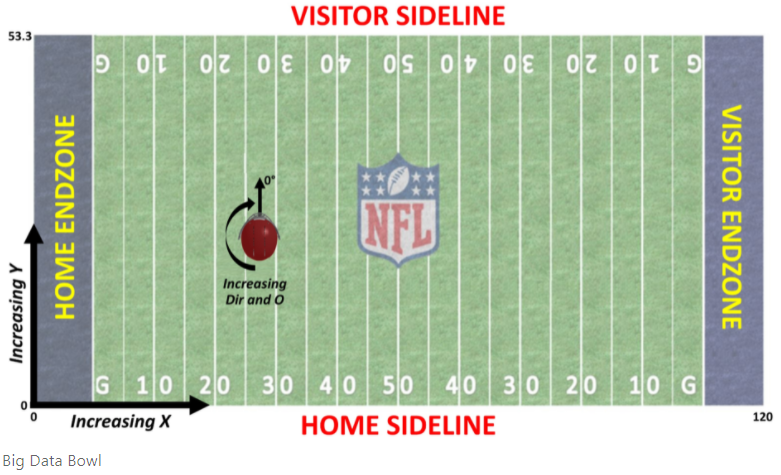

In [9]:
# show image provided by BDB to help explain meaning of x, y, o and dir variables
Image("drive/MyDrive/BDB_2021/tracking_data_explanatory_viz.PNG")

*   X - player position along the long axis of the field (0 to 120 yards)
*   Y - player position along the short axis of the field (0 to 53.3 yards)
*   S - speed in yards/second
*   A - acceleration in yards/second squared
*   O - orientation of player in degrees (aka where they are facing)
*   Dir - angle of player postion in degrees (aka direction of movement)


In [10]:
# Steal someone's excellent function to visualize tracking data on a football field
# https://www.kaggle.com/robikscube/nfl-big-data-bowl-plotting-player-position

def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

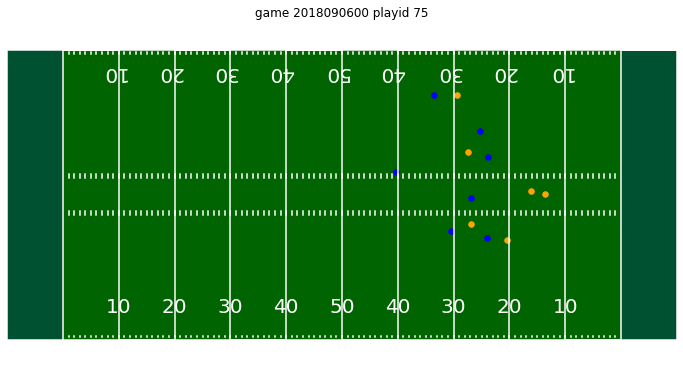

In [11]:
# visualize first play of tracking data where pass is being attempted.
# away team players (offense in this instance) are shown as orange and home team (defense) shown as blue
fig, ax = create_football_field()
df_tracking.query("gameid == '2018090600' and playid == '75' and team == 'away'") \
    .plot(x='x', y='y', kind='scatter', ax=ax, color='orange', s=30, legend='away')
df_tracking.query("gameid == '2018090600' and playid == '75' and team == 'home'") \
    .plot(x='x', y='y', kind='scatter', ax=ax, color='blue', s=30, legend='home')
plt.title('game 2018090600 playid 75')
plt.show()

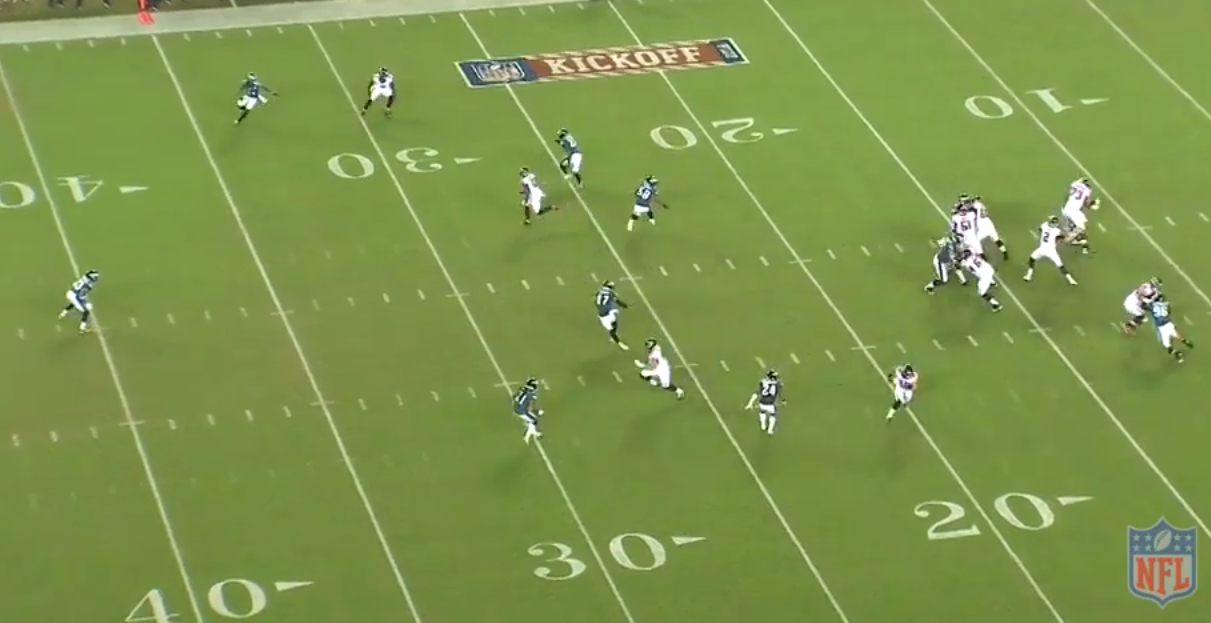

In [12]:
# compare to how this frame looked on the TV broadcast to make sure I have not screwed something up
Image("drive/MyDrive/BDB_2021/2018090600_75.PNG")

Looks good! It is important to note that the focus of the 2021 Big Data Bowl was on measuring pass coverage. As a result the data does not include tracking data for offensive and defensive lineman, therefore, those players are not shown in the plot a couple cells above.

In [13]:
# Standardize x, y coordinates so we can have all plays oriented where offensive is moving left to right along the x axis of the field
df_tracking['toleft'] = df_tracking['playdirection'] == 'left'
df_tracking['x_std'] = df_tracking['x']
df_tracking.loc[df_tracking['toleft'], 'x_std'] = 120 - df_tracking.loc[df_tracking['toleft'], 'x']
df_tracking['y_std'] = df_tracking['y']
df_tracking.loc[df_tracking['toleft'], 'y_std'] = 160/3 - df_tracking.loc[df_tracking['toleft'], 'y']

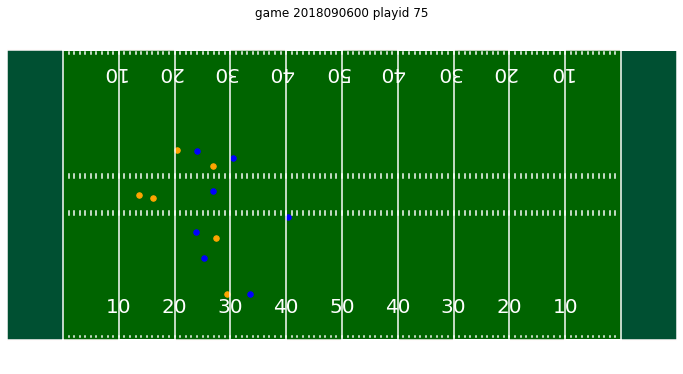

In [14]:
# visualize first play again with standardized x and y coordinates to make sure it still looks correct
# away team players (offense in this instance) are shown as orange and home team (defense) shown as blue
fig, ax = create_football_field()
df_tracking.query("gameid == '2018090600' and playid == '75' and team == 'away'") \
    .plot(x='x_std', y='y_std', kind='scatter', ax=ax, color='orange', s=30, legend='away')
df_tracking.query("gameid == '2018090600' and playid == '75' and team == 'home'") \
    .plot(x='x_std', y='y_std', kind='scatter', ax=ax, color='blue', s=30, legend='home')
plt.title('game 2018090600 playid 75')
plt.show()

In [15]:
# other feature engineering to standardize dir and o variables as well as get speed in x and y directions
df_tracking['dir_rad'] = np.mod(90 - df_tracking.dir, 360) * math.pi/180.0
df_tracking['dir_std'] = df_tracking.dir_rad
df_tracking.loc[df_tracking.toleft, 'dir_std'] = np.mod(np.pi + df_tracking.loc[df_tracking.toleft, 'dir_rad'], 2*np.pi)

df_tracking['o_rad'] = np.mod(90 - df_tracking.o, 360) * math.pi/180.0
df_tracking['o_std'] = df_tracking.o_rad
df_tracking.loc[df_tracking.toleft, 'o_std'] = np.mod(np.pi + df_tracking.loc[df_tracking.toleft, 'o_rad'], 2*np.pi)

df_tracking['sx'] = df_tracking['s'] * df_tracking['dir_std'].apply(math.cos)
df_tracking['sy'] = df_tracking['s'] * df_tracking['dir_std'].apply(math.sin)

In [16]:
# create dataframe for location of QB
qb_loc = df_tracking.loc[df_tracking['position'] == 'QB', ['gameid', 'playid', 'frameid', 'x_std', 'y_std', 'sx', 'sy']]
qb_loc = qb_loc.rename(columns = {'x_std': 'qb_x_std', 'y_std': 'qb_y_std', 'sx': 'qb_sx', 'sy': 'qb_sy'})
qb_loc.head()

,gameid,playid,frameid,qb_x_std,qb_y_std,qb_sx,qb_sy
490,2018090600,75,36,23.57,26.553333,0.376249,-0.751024
1246,2018090600,146,31,66.12,23.613333,0.026800,-0.459219
1974,2018090600,168,34,64.89,24.623333,-0.712682,1.488148
2716,2018090600,190,39,61.89,26.813333,-0.025754,2.379861
3566,2018090600,256,31,103.03,29.273333,0.075467,-0.896830


In [17]:
# there are plays with two qbs on offense. going to get rid of that nonsense to focus on typical passing plays
qb_counts = qb_loc.groupby(['gameid', 'playid', 'frameid']).size().reset_index(name = 'qbs_in_play')
qb_counts = qb_counts[qb_counts.qbs_in_play == 1]
qb_counts.head()

,gameid,playid,frameid,qbs_in_play
0,2018090600,1037,47,1
1,2018090600,1061,38,1
2,2018090600,1085,36,1
3,2018090600,1202,40,1
4,2018090600,1226,47,1


In [18]:
# joining qb_counts with qb_loc. qb_counts already limited to 1 qb plays so inner join will get rid of 2 qb plays
qb_loc = pd.merge(qb_loc, qb_counts, how = 'inner', on = ['gameid', 'playid', 'frameid'])
del qb_counts
qb_loc.head()

,gameid,playid,frameid,qb_x_std,qb_y_std,qb_sx,qb_sy,qbs_in_play
0,2018090600,75,36,23.57,26.553333,0.376249,-0.751024,1
1,2018090600,146,31,66.12,23.613333,0.026800,-0.459219,1
2,2018090600,168,34,64.89,24.623333,-0.712682,1.488148,1
3,2018090600,190,39,61.89,26.813333,-0.025754,2.379861,1
4,2018090600,256,31,103.03,29.273333,0.075467,-0.896830,1


In [19]:
# create dataframe for location of football
fb_loc = df_tracking.loc[df_tracking['team'] == 'football', ['gameid', 'playid', 'frameid', 'x_std', 'y_std']]
fb_loc = fb_loc.rename(columns = {'x_std': 'fb_x_std', 'y_std': 'fb_y_std'})
fb_loc.head()

,gameid,playid,frameid,fb_x_std,fb_y_std
503,2018090600,75,36,23.10,26.363333
1259,2018090600,146,31,65.39,23.653333
1987,2018090600,168,34,65.49,24.673333
2729,2018090600,190,39,61.60,26.273333
3577,2018090600,256,31,102.52,28.893333


In [20]:
# Join fb_loc to df_tracking on gameid, playid, frameid
df = pd.merge(fb_loc, df_tracking, how = 'inner', on = ['gameid', 'playid', 'frameid'])

# Join qb_loc to df_tracking on gameid, playid, frameid
df = pd.merge(qb_loc, df, how = 'inner', on = ['gameid', 'playid', 'frameid'])

# delete qbs in play column and other stuff
del df['qbs_in_play']
del qb_loc
del fb_loc
del df_tracking

In [21]:
# how many plays are we down to now
len(df.id.unique())

17620

In [22]:
# look at our first play again to see if this worked
df[df.id == ex_play]

,gameid,playid,frameid,qb_x_std,qb_y_std,qb_sx,qb_sy,fb_x_std,fb_y_std,x,y,s,a,o,dir,nflid,displayname,jerseynumber,position,team,playdirection,id,toleft,x_std,y_std,dir_rad,dir_std,o_rad,o_std,sx,sy
0,2018090600,75,36,23.57,26.553333,0.376249,-0.751024,23.1,26.363333,96.43,26.78,0.84,2.05,356.40,333.39,310,Matt Ryan,2,QB,away,left,20180906007536,True,23.57,26.553333,2.035228,5.176821,1.633628,4.775221,0.376249,-0.751024
1,2018090600,75,36,23.57,26.553333,0.376249,-0.751024,23.1,26.363333,84.82,38.33,5.53,4.30,295.34,318.58,79848,Malcolm Jenkins,27,SS,home,left,20180906007536,True,35.18,15.003333,2.293712,5.435304,2.699326,5.840919,3.658502,-4.146837
2,2018090600,75,36,23.57,26.553333,0.376249,-0.751024,23.1,26.363333,80.69,44.91,3.11,6.67,155.11,297.88,2495454,Julio Jones,11,WR,away,left,20180906007536,True,39.31,8.423333,2.654995,5.796588,5.146801,2.005209,2.749019,-1.454302
3,2018090600,75,36,23.57,26.553333,0.376249,-0.751024,23.1,26.363333,86.02,18.64,3.52,0.69,28.19,216.15,2495613,Corey Graham,24,FS,home,left,20180906007536,True,33.98,34.693333,4.081452,0.939860,1.078788,4.220381,2.076452,2.842313
4,2018090600,75,36,23.57,26.553333,0.376249,-0.751024,23.1,26.363333,82.65,34.56,6.35,1.21,262.06,272.78,2533040,Mohamed Sanu,12,WR,away,left,20180906007536,True,37.35,18.773333,3.093073,6.234665,3.280172,0.138579,6.342527,-0.307982
5,2018090600,75,36,23.57,26.553333,0.376249,-0.751024,23.1,26.363333,69.63,30.81,2.93,2.65,79.24,315.98,2534832,Rodney McLeod,23,FS,home,left,20180906007536,True,50.37,22.523333,2.339090,5.480683,0.187797,3.329390,2.036085,-2.106955
6,2018090600,75,36,23.57,26.553333,0.376249,-0.751024,23.1,26.363333,93.81,27.30,3.92,3.23,293.03,332.35,2543583,Devonta Freeman,24,RB,away,left,20180906007536,True,26.19,26.033333,2.053380,5.194973,2.739643,5.881236,1.819151,-3.472332
7,2018090600,75,36,23.57,26.553333,0.376249,-0.751024,23.1,26.363333,86.10,33.53,3.75,1.49,52.23,311.29,2552315,Jordan Hicks,58,MLB,home,left,20180906007536,True,33.90,19.803333,2.420946,5.562539,0.659211,3.800804,2.817672,-2.474515
8,2018090600,75,36,23.57,26.553333,0.376249,-0.751024,23.1,26.363333,79.51,20.00,2.99,0.69,78.25,259.75,2552689,Ronald Darby,21,CB,home,left,20180906007536,True,40.49,33.333333,3.320489,0.178896,0.205076,3.346669,2.942282,0.532051
9,2018090600,75,36,23.57,26.553333,0.376249,-0.751024,23.1,26.363333,76.53,44.93,4.68,2.18,182.14,277.48,2555383,Jalen Mills,31,CB,home,left,20180906007536,True,43.47,8.403333,3.011042,6.152635,4.675039,1.533446,4.640175,-0.609243


In [23]:
# calculate differences from player position to football position
df['player_minus_fb_x'] = df['fb_x_std'] - df['x_std']
df['player_minus_fb_y'] = df['fb_y_std'] - df['y_std']
df['dist_to_ball'] = np.sqrt(df['player_minus_fb_x']**2 + df['player_minus_fb_y']**2)

# calculate differences from player position to qb position
df['player_minus_qb_x'] = df['qb_x_std'] - df['x_std']
df['player_minus_qb_y'] = df['qb_y_std'] - df['y_std']
df['dist_to_qb'] = np.sqrt(df['player_minus_qb_x']**2 + df['player_minus_qb_y']**2)

# calculate differences from player speed to qb speed
df['player_minus_qb_sx'] = df['qb_sx'] - df['sx']
df['player_minus_qb_sy'] = df['qb_sy'] - df['sy']

In [24]:
# Read in games data
df_games = pd.read_csv('drive/MyDrive/BDB_2021/games.csv').clean_names()

# get rid of stuff I'm not going to use
del df_games['gametimeeastern']
del df_games['gamedate']
del df_games['week']

# convert gameid to string
df_games['gameid'] = df_games['gameid'].astype('str')
df_games.head()

,gameid,hometeamabbr,visitorteamabbr
0,2018090600,PHI,ATL
1,2018090901,CLE,PIT
2,2018090902,IND,CIN
3,2018090903,MIA,TEN
4,2018090900,BAL,BUF


In [25]:
# Join df_games to df on gameid
df = pd.merge(df, df_games, how = 'inner', on = 'gameid')

# get rid of games
del df_games

In [26]:
# Read in targeted receiver data
df_targeted_receiver = pd.read_csv('drive/MyDrive/BDB_2021/targetedReceiver.csv').clean_names()

# get rid of plays without a targeted receiver
df_targeted_receiver = df_targeted_receiver.dropna()

# fill na's in targetnflid then convert to integer
df_targeted_receiver['targetnflid'] = df_targeted_receiver['targetnflid'].fillna(0).astype('int')

# convert ids to strings
df_targeted_receiver['gameid'] = df_targeted_receiver['gameid'].astype('str')
df_targeted_receiver['playid'] = df_targeted_receiver['playid'].astype('str')
df_targeted_receiver.head()

,gameid,playid,targetnflid
0,2018090600,75,2495454
1,2018090600,146,2560854
2,2018090600,168,2543583
3,2018090600,190,2495454
4,2018090600,256,2543583


In [27]:
# Join df_targeted_receiver to df on gameid & playid
df = pd.merge(df_targeted_receiver, df, how = 'inner', on = ['gameid', 'playid'])

# get rid of targeted receiver
del df_targeted_receiver

In [28]:
# read in plays data, filter to play_type_pass
play_cols = ['gameId', 'playId', 'playDescription', 'possessionTeam', 'playType', 'passResult']
df_plays = pd.read_csv('drive/MyDrive/BDB_2021/plays.csv', usecols = play_cols).clean_names()
df_plays = df_plays[df_plays.playtype == 'play_type_pass']

# convert ids to strings
df_plays['gameid'] = df_plays['gameid'].astype('str')
df_plays['playid'] = df_plays['playid'].astype('str')

# View data for the first play
df_plays[(df_plays.gameid == '2018090600') & (df_plays.playid == '75')]

,gameid,playid,playdescription,possessionteam,playtype,passresult
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,ATL,play_type_pass,C


In [29]:
# Join df_plays to df on gameid & playid
df = pd.merge(df, df_plays, how = 'inner', on = ['gameid', 'playid'])

# get rid of plays data
del df_plays

In [30]:
# how many plays do we have
len(df.id.unique())

16632

In [31]:
# Determine what players are on offense and what players are on defense

# new column teamonoffense, fill with 'home'
df['teamonoffense'] = 'home'

# if possessionteam is not the home team change teamonoffense value to 'away'
df.loc[df.possessionteam != df.hometeamabbr, 'teamonoffense'] = 'away'

# new column isonoffense, if team for row with playerid equals teamonoffense return True
df['isonoffense'] = df.team == df.teamonoffense # football is going to show as False for isonoffense fyi...

# new column for is targeted receiver, this was the target label in the original project goal
df['istarget'] = df.targetnflid == df.nflid
df['istarget'] = df['istarget'].astype(int)

# new column for is qb
df['isqb'] = df.position == 'QB'
df['isqb'] = df['isqb'].astype(int)

In [32]:
# create dataframe for location of targeted receiver
tr_loc = df.loc[df['istarget'] == 1, ['gameid', 'playid', 'frameid', 'x_std', 'y_std']]
tr_loc = tr_loc.rename(columns = {'x_std': 'tr_x_std', 'y_std': 'tr_y_std'})
tr_loc.head()

,gameid,playid,frameid,tr_x_std,tr_y_std
2,2018090600,75,36,39.31,8.423333
26,2018090600,146,31,74.49,16.423333
33,2018090600,168,34,68.17,39.643333
44,2018090600,190,39,84.30,32.263333
60,2018090600,256,31,110.83,18.133333


In [33]:
# Join tr_loc to df on gameid, playid, frameid
df = pd.merge(tr_loc, df, how = 'inner', on = ['gameid', 'playid', 'frameid'])
del tr_loc

In [34]:
# calculate differences from player positions and targeted receiver position
df['player_minus_tr_x'] = df['tr_x_std'] - df['x_std']
df['player_minus_tr_y'] = df['tr_y_std'] - df['y_std']
df['dist_to_tr'] = np.sqrt(df['player_minus_tr_x']**2 + df['player_minus_tr_y']**2)

In [35]:
# look at our first play now that it is joined with other data
df[df.id == ex_play].head()

,gameid,playid,frameid,tr_x_std,tr_y_std,targetnflid,qb_x_std,qb_y_std,qb_sx,qb_sy,fb_x_std,fb_y_std,x,y,s,a,o,dir,nflid,displayname,jerseynumber,position,team,playdirection,id,toleft,x_std,y_std,dir_rad,dir_std,o_rad,o_std,sx,sy,player_minus_fb_x,player_minus_fb_y,dist_to_ball,player_minus_qb_x,player_minus_qb_y,dist_to_qb,player_minus_qb_sx,player_minus_qb_sy,hometeamabbr,visitorteamabbr,playdescription,possessionteam,playtype,passresult,teamonoffense,isonoffense,istarget,isqb,player_minus_tr_x,player_minus_tr_y,dist_to_tr
0,2018090600,75,36,39.31,8.423333,2495454,23.57,26.553333,0.376249,-0.751024,23.1,26.363333,96.43,26.78,0.84,2.05,356.40,333.39,310,Matt Ryan,2,QB,away,left,20180906007536,True,23.57,26.553333,2.035228,5.176821,1.633628,4.775221,0.376249,-0.751024,-0.47,-0.19,0.506952,0.00,0.00,0.000000,0.000000,0.000000,PHI,ATL,(15:00) M.Ryan pass short right to J.Jones pus...,ATL,play_type_pass,C,away,True,0,1,15.74,-18.13,24.009259
1,2018090600,75,36,39.31,8.423333,2495454,23.57,26.553333,0.376249,-0.751024,23.1,26.363333,84.82,38.33,5.53,4.30,295.34,318.58,79848,Malcolm Jenkins,27,SS,home,left,20180906007536,True,35.18,15.003333,2.293712,5.435304,2.699326,5.840919,3.658502,-4.146837,-12.08,11.36,16.582400,-11.61,11.55,16.376648,-3.282254,3.395814,PHI,ATL,(15:00) M.Ryan pass short right to J.Jones pus...,ATL,play_type_pass,C,away,False,0,0,4.13,-6.58,7.768739
2,2018090600,75,36,39.31,8.423333,2495454,23.57,26.553333,0.376249,-0.751024,23.1,26.363333,80.69,44.91,3.11,6.67,155.11,297.88,2495454,Julio Jones,11,WR,away,left,20180906007536,True,39.31,8.423333,2.654995,5.796588,5.146801,2.005209,2.749019,-1.454302,-16.21,17.94,24.178662,-15.74,18.13,24.009259,-2.372770,0.703278,PHI,ATL,(15:00) M.Ryan pass short right to J.Jones pus...,ATL,play_type_pass,C,away,True,1,0,0.00,0.00,0.000000
3,2018090600,75,36,39.31,8.423333,2495454,23.57,26.553333,0.376249,-0.751024,23.1,26.363333,86.02,18.64,3.52,0.69,28.19,216.15,2495613,Corey Graham,24,FS,home,left,20180906007536,True,33.98,34.693333,4.081452,0.939860,1.078788,4.220381,2.076452,2.842313,-10.88,-8.33,13.702675,-10.41,-8.14,13.214677,-1.700204,-3.593337,PHI,ATL,(15:00) M.Ryan pass short right to J.Jones pus...,ATL,play_type_pass,C,away,False,0,0,5.33,-26.27,26.805257
4,2018090600,75,36,39.31,8.423333,2495454,23.57,26.553333,0.376249,-0.751024,23.1,26.363333,82.65,34.56,6.35,1.21,262.06,272.78,2533040,Mohamed Sanu,12,WR,away,left,20180906007536,True,37.35,18.773333,3.093073,6.234665,3.280172,0.138579,6.342527,-0.307982,-14.25,7.59,16.145297,-13.78,7.78,15.824563,-5.966278,-0.443042,PHI,ATL,(15:00) M.Ryan pass short right to J.Jones pus...,ATL,play_type_pass,C,away,True,0,0,1.96,-10.35,10.533950


Input shape needed for my model is number of plays, number of offensive players, number of defensive players, number of features. 

Not all plays have the same number of offensive and defensive players in this dataset. I could use an input shape for max number of players on each side of the ball but not sure we would do with plays that don't have max number of players. If I fill empty positions of arrays with zeros or means or medians that doesn't seem wise. I could filter the data to the most common combination of offensive and defensive players, 6 and 7 respectively. However, this would reduce the unaugmented training data down to 8,690 plays or nearly half of what we have now. 

I'd rather not cut out that much of the data so making the decision to keep plays with 6 offensive players and keep the defensive player information for the 7 defenders furthest from the ball at the time of the throw. In theory, those players should be responsible for pass coverage.

In [36]:
# How many offensive players are in the plays we have
off_players_in_frame = df[df.isonoffense == True].groupby(["gameid", "playid", "frameid"], as_index = False)['x'].count()
off_players_in_frame = off_players_in_frame.rename(columns = {'x': 'num_off_players'})
off_players_in_frame.num_off_players.value_counts()

6     16395
5       204
11        2
Name: num_off_players, dtype: int64

In [37]:
## filtering to plays with 6 offensive players as that's the most common
off_players_in_frame = off_players_in_frame[off_players_in_frame.num_off_players == 6]
off_players_in_frame.head()

,gameid,playid,frameid,num_off_players
0,2018090600,1037,47,6
1,2018090600,1061,38,6
2,2018090600,1085,36,6
3,2018090600,1202,40,6
4,2018090600,1295,35,6


In [38]:
# how many defensive players are in these plays
def_players_in_frame = df[(df.isonoffense == False) & (df.team != 'football')].groupby(["gameid", "playid", "frameid"], as_index = False)['x'].count()
def_players_in_frame = def_players_in_frame.rename(columns = {'x': 'num_def_players'})
def_players_in_frame.num_def_players.value_counts()

7     8814
8     4338
9     2680
10     588
6      104
11      45
5       24
4        1
Name: num_def_players, dtype: int64

In [39]:
# limiting to plays with 7 or more defenders since those are the most common
def_players_in_frame = def_players_in_frame[def_players_in_frame.num_def_players >= 7]
def_players_in_frame.head()

,gameid,playid,frameid,num_def_players
0,2018090600,1037,47,7
1,2018090600,1061,38,7
2,2018090600,1085,36,8
3,2018090600,1202,40,8
4,2018090600,1295,35,7


In [40]:
# Join number of offensive and defensive players to df on gameid & playid & frameid
df = pd.merge(df, off_players_in_frame, how = 'inner', on = ['gameid', 'playid', 'frameid'])
df = pd.merge(df, def_players_in_frame, how = 'inner', on = ['gameid', 'playid', 'frameid'])

In [41]:
len(df.id.unique())

16285

In [42]:
# get dataframe for defenders, sort by distance from the ball, keep 7 defenders furthest from the ball
df_defenders = df[(df.isonoffense == False) & (df.team != 'football')].sort_values(by=['id', 'dist_to_ball'], axis=0, ascending=[True, False]).groupby('id').head(7)
def_players_in_frame = df_defenders.groupby(["gameid", "playid", "frameid"], as_index=False)['x'].count()
def_players_in_frame = def_players_in_frame.rename(columns = {'x': 'num_def_players'})
def_players_in_frame.num_def_players.value_counts()

7    16285
Name: num_def_players, dtype: int64

In [43]:
# create dataframe of offensive players
df_offense = df[df.isonoffense == True]

In [44]:
# combine offensive and defensive player dataframes
df = pd.concat([df_offense, df_defenders]).sort_values(by='id').reset_index(drop=True)

In [45]:
df

,gameid,playid,frameid,tr_x_std,tr_y_std,targetnflid,qb_x_std,qb_y_std,qb_sx,qb_sy,fb_x_std,fb_y_std,x,y,s,a,o,dir,nflid,displayname,jerseynumber,position,team,playdirection,id,toleft,x_std,y_std,dir_rad,dir_std,o_rad,o_std,sx,sy,player_minus_fb_x,player_minus_fb_y,dist_to_ball,player_minus_qb_x,player_minus_qb_y,dist_to_qb,player_minus_qb_sx,player_minus_qb_sy,hometeamabbr,visitorteamabbr,playdescription,possessionteam,playtype,passresult,teamonoffense,isonoffense,istarget,isqb,player_minus_tr_x,player_minus_tr_y,dist_to_tr,num_off_players,num_def_players
0,2018090600,1037,47,64.49,36.843333,2552600,43.83,31.033333,1.140111,1.366948,44.97,30.843333,43.94,33.11,4.54,1.01,57.92,316.20,2543850,Ricardo Allen,37,SS,away,left,2018090600103747,True,76.06,20.223333,2.335251,5.476843,0.559902,3.701494,3.142330,-3.276791,-31.09,10.62,32.853805,-32.23,10.81,33.994544,-2.002219,4.643739,PHI,ATL,(12:53) (Shotgun) N.Foles pass short left to N...,PHI,play_type_pass,C,home,False,0,0,-11.57,16.62,20.250662,6,7
1,2018090600,1037,47,64.49,36.843333,2552600,43.83,31.033333,1.140111,1.366948,44.97,30.843333,68.32,41.26,5.70,1.94,89.15,357.36,2553502,DeAndre Carter,16,WR,home,left,2018090600103747,True,51.68,12.073333,1.616873,4.758466,0.014835,3.156428,0.262544,-5.693950,-6.71,18.77,19.933314,-7.85,18.96,20.520821,0.877567,7.060898,PHI,ATL,(12:53) (Shotgun) N.Foles pass short left to N...,PHI,play_type_pass,C,home,True,0,0,12.81,24.77,27.886359,6,7
2,2018090600,1037,47,64.49,36.843333,2552600,43.83,31.033333,1.140111,1.366948,44.97,30.843333,55.51,16.49,0.61,5.10,47.53,174.69,2552600,Nelson Agholor,13,WR,home,left,2018090600103747,True,64.49,36.843333,4.805066,1.663473,0.741241,3.882834,-0.056452,0.607382,-19.52,-6.00,20.421322,-20.66,-5.81,21.461400,1.196563,0.759566,PHI,ATL,(12:53) (Shotgun) N.Foles pass short left to N...,PHI,play_type_pass,C,home,True,1,0,0.00,0.00,0.000000,6,7
3,2018090600,1037,47,64.49,36.843333,2552600,43.83,31.033333,1.140111,1.366948,44.97,30.843333,75.34,23.80,2.08,5.02,270.50,121.03,2552582,Jay Ajayi,26,RB,home,left,2018090600103747,True,44.66,29.533333,5.741610,2.600017,3.132866,6.274459,-1.782347,1.072213,0.31,1.31,1.346180,-0.83,1.50,1.714322,2.922458,0.294735,PHI,ATL,(12:53) (Shotgun) N.Foles pass short left to N...,PHI,play_type_pass,C,home,True,0,0,19.83,7.31,21.134451,6,7
4,2018090600,1037,47,64.49,36.843333,2552600,43.83,31.033333,1.140111,1.366948,44.97,30.843333,54.29,24.45,4.69,5.14,196.63,259.43,2540158,Zach Ertz,86,TE,home,left,2018090600103747,True,65.71,28.883333,3.326074,0.184481,4.422141,1.280548,4.610418,0.860318,-20.74,1.96,20.832407,-21.88,2.15,21.985379,-3.470307,0.506630,PHI,ATL,(12:53) (Shotgun) N.Foles pass short left to N...,PHI,play_type_pass,C,home,True,0,0,-1.22,7.96,8.052950,6,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211700,2018123015,991,29,49.58,12.023333,2506106,40.21,22.953333,-0.132254,-0.513234,39.47,22.903333,71.28,24.74,3.21,2.06,260.42,266.14,2558886,Darrell Daniels,81,TE,away,left,201812301599129,True,48.72,28.593333,3.208962,0.067370,3.308795,0.167203,3.202718,0.216093,-9.25,-5.69,10.859954,-8.51,-5.64,10.209295,-3.334972,-0.729327,SEA,ARI,(15:00) (Shotgun) J.Rosen pass short right to ...,ARI,play_type_pass,C,away,True,0,0,0.86,-16.57,16.592302,6,7
211701,2018123015,991,29,49.58,12.023333,2506106,40.21,22.953333,-0.132254,-0.513234,39.47,22.903333,75.62,29.20,5.05,2.02,291.01,281.22,2560711,Chase Edmonds,29,RB,away,left,201812301599129,True,44.38,24.133333,2.945767,6.087359,2.774899,5.916492,4.953481,-0.982613,-4.91,-1.23,5.061719,-4.17,-1.18,4.333740,-5.085734,0.469379,SEA,ARI,(15:00) (Shotgun) J.Rosen pass short right to ...,ARI,play_type_pass,C,away,True,0,0,5.20,-12.11,13.179230,6,7
211702,2018123015,991,29,49.58,12.023333,2506106,40.21,22.953333,-0.132254,-0.513234,39.47,22.903333,79.7

Makes sense we have 211,705 rows. 16,285 unique plays with 13 rows for each play. We have rows for 6 offensive players and 7 defensive players in each play.

In [46]:
# What type of passresults do we have in the data?
df['passresult'].unique()

array(['C', 'I', 'IN'], dtype=object)

In [47]:
# we are going to try and predict whether a pass was completed so we don't care if the pass is Incomplete (I) or Intercepted (IN)

# new column for result where completions will show as 1 and incomplete or intercepted will show as 0
df['result'] = df.passresult == 'C'
df['result'] = df['result'].astype(int)
df.head()

,gameid,playid,frameid,tr_x_std,tr_y_std,targetnflid,qb_x_std,qb_y_std,qb_sx,qb_sy,fb_x_std,fb_y_std,x,y,s,a,o,dir,nflid,displayname,jerseynumber,position,team,playdirection,id,toleft,x_std,y_std,dir_rad,dir_std,o_rad,o_std,sx,sy,player_minus_fb_x,player_minus_fb_y,dist_to_ball,player_minus_qb_x,player_minus_qb_y,dist_to_qb,player_minus_qb_sx,player_minus_qb_sy,hometeamabbr,visitorteamabbr,playdescription,possessionteam,playtype,passresult,teamonoffense,isonoffense,istarget,isqb,player_minus_tr_x,player_minus_tr_y,dist_to_tr,num_off_players,num_def_players,result
0,2018090600,1037,47,64.49,36.843333,2552600,43.83,31.033333,1.140111,1.366948,44.97,30.843333,43.94,33.11,4.54,1.01,57.92,316.20,2543850,Ricardo Allen,37,SS,away,left,2018090600103747,True,76.06,20.223333,2.335251,5.476843,0.559902,3.701494,3.142330,-3.276791,-31.09,10.62,32.853805,-32.23,10.81,33.994544,-2.002219,4.643739,PHI,ATL,(12:53) (Shotgun) N.Foles pass short left to N...,PHI,play_type_pass,C,home,False,0,0,-11.57,16.62,20.250662,6,7,1
1,2018090600,1037,47,64.49,36.843333,2552600,43.83,31.033333,1.140111,1.366948,44.97,30.843333,68.32,41.26,5.70,1.94,89.15,357.36,2553502,DeAndre Carter,16,WR,home,left,2018090600103747,True,51.68,12.073333,1.616873,4.758466,0.014835,3.156428,0.262544,-5.693950,-6.71,18.77,19.933314,-7.85,18.96,20.520821,0.877567,7.060898,PHI,ATL,(12:53) (Shotgun) N.Foles pass short left to N...,PHI,play_type_pass,C,home,True,0,0,12.81,24.77,27.886359,6,7,1
2,2018090600,1037,47,64.49,36.843333,2552600,43.83,31.033333,1.140111,1.366948,44.97,30.843333,55.51,16.49,0.61,5.10,47.53,174.69,2552600,Nelson Agholor,13,WR,home,left,2018090600103747,True,64.49,36.843333,4.805066,1.663473,0.741241,3.882834,-0.056452,0.607382,-19.52,-6.00,20.421322,-20.66,-5.81,21.461400,1.196563,0.759566,PHI,ATL,(12:53) (Shotgun) N.Foles pass short left to N...,PHI,play_type_pass,C,home,True,1,0,0.00,0.00,0.000000,6,7,1
3,2018090600,1037,47,64.49,36.843333,2552600,43.83,31.033333,1.140111,1.366948,44.97,30.843333,75.34,23.80,2.08,5.02,270.50,121.03,2552582,Jay Ajayi,26,RB,home,left,2018090600103747,True,44.66,29.533333,5.741610,2.600017,3.132866,6.274459,-1.782347,1.072213,0.31,1.31,1.346180,-0.83,1.50,1.714322,2.922458,0.294735,PHI,ATL,(12:53) (Shotgun) N.Foles pass short left to N...,PHI,play_type_pass,C,home,True,0,0,19.83,7.31,21.134451,6,7,1
4,2018090600,1037,47,64.49,36.843333,2552600,43.83,31.033333,1.140111,1.366948,44.97,30.843333,54.29,24.45,4.69,5.14,196.63,259.43,2540158,Zach Ertz,86,TE,home,left,2018090600103747,True,65.71,28.883333,3.326074,0.184481,4.422141,1.280548,4.610418,0.860318,-20.74,1.96,20.832407,-21.88,2.15,21.985379,-3.470307,0.506630,PHI,ATL,(12:53) (Shotgun) N.Foles pass short left to N...,PHI,play_type_pass,C,home,True,0,0,-1.22,7.96,8.052950,6,7,1


In [48]:
# uncomment the below line to save processed data as a csv
#df.to_csv('drive/MyDrive/BDB_2021/processeddata.csv')

To increase the size of our training data I'm going to flip the Y coordinates and related features. This would essentially create a new mirrored frame.

In [49]:
# take a random sample of plays from df
sample_ids = np.random.choice(df.id.unique(), int(0.5*len(df.id.unique())), replace=False)

# create dataframe of random plays, flip y coordinates and related features
df_sample = df.loc[df.id.isin(sample_ids)].copy()
df_sample['y_std'] = 160/3 - df_sample['y_std']
df_sample['dir_std'] = df_sample['dir_std'].apply(lambda x: 2*np.pi - x)
df_sample['sy'] = df_sample['s'] * df_sample['dir_std'].apply(math.sin)
df_sample['id'] = df_sample['id'].apply(lambda x: x+'_aug')

In [50]:
# combine actual plays with augmented plays
df = pd.concat([df, df_sample])
df = df.reset_index(drop=True)

In [51]:
# makes sense now that we have 24,427 plays (16,285 original + 8,142 augmented) times 13 rows for each play
len(df)

317551

In [52]:
df

,gameid,playid,frameid,tr_x_std,tr_y_std,targetnflid,qb_x_std,qb_y_std,qb_sx,qb_sy,fb_x_std,fb_y_std,x,y,s,a,o,dir,nflid,displayname,jerseynumber,position,team,playdirection,id,toleft,x_std,y_std,dir_rad,dir_std,o_rad,o_std,sx,sy,player_minus_fb_x,player_minus_fb_y,dist_to_ball,player_minus_qb_x,player_minus_qb_y,dist_to_qb,player_minus_qb_sx,player_minus_qb_sy,hometeamabbr,visitorteamabbr,playdescription,possessionteam,playtype,passresult,teamonoffense,isonoffense,istarget,isqb,player_minus_tr_x,player_minus_tr_y,dist_to_tr,num_off_players,num_def_players,result
0,2018090600,1037,47,64.49,36.843333,2552600,43.83,31.033333,1.140111,1.366948,44.97,30.843333,43.94,33.11,4.54,1.01,57.92,316.20,2543850,Ricardo Allen,37,SS,away,left,2018090600103747,True,76.06,20.223333,2.335251,5.476843,0.559902,3.701494,3.142330,-3.276791,-31.09,10.62,32.853805,-32.23,10.81,33.994544,-2.002219,4.643739,PHI,ATL,(12:53) (Shotgun) N.Foles pass short left to N...,PHI,play_type_pass,C,home,False,0,0,-11.57,16.62,20.250662,6,7,1
1,2018090600,1037,47,64.49,36.843333,2552600,43.83,31.033333,1.140111,1.366948,44.97,30.843333,68.32,41.26,5.70,1.94,89.15,357.36,2553502,DeAndre Carter,16,WR,home,left,2018090600103747,True,51.68,12.073333,1.616873,4.758466,0.014835,3.156428,0.262544,-5.693950,-6.71,18.77,19.933314,-7.85,18.96,20.520821,0.877567,7.060898,PHI,ATL,(12:53) (Shotgun) N.Foles pass short left to N...,PHI,play_type_pass,C,home,True,0,0,12.81,24.77,27.886359,6,7,1
2,2018090600,1037,47,64.49,36.843333,2552600,43.83,31.033333,1.140111,1.366948,44.97,30.843333,55.51,16.49,0.61,5.10,47.53,174.69,2552600,Nelson Agholor,13,WR,home,left,2018090600103747,True,64.49,36.843333,4.805066,1.663473,0.741241,3.882834,-0.056452,0.607382,-19.52,-6.00,20.421322,-20.66,-5.81,21.461400,1.196563,0.759566,PHI,ATL,(12:53) (Shotgun) N.Foles pass short left to N...,PHI,play_type_pass,C,home,True,1,0,0.00,0.00,0.000000,6,7,1
3,2018090600,1037,47,64.49,36.843333,2552600,43.83,31.033333,1.140111,1.366948,44.97,30.843333,75.34,23.80,2.08,5.02,270.50,121.03,2552582,Jay Ajayi,26,RB,home,left,2018090600103747,True,44.66,29.533333,5.741610,2.600017,3.132866,6.274459,-1.782347,1.072213,0.31,1.31,1.346180,-0.83,1.50,1.714322,2.922458,0.294735,PHI,ATL,(12:53) (Shotgun) N.Foles pass short left to N...,PHI,play_type_pass,C,home,True,0,0,19.83,7.31,21.134451,6,7,1
4,2018090600,1037,47,64.49,36.843333,2552600,43.83,31.033333,1.140111,1.366948,44.97,30.843333,54.29,24.45,4.69,5.14,196.63,259.43,2540158,Zach Ertz,86,TE,home,left,2018090600103747,True,65.71,28.883333,3.326074,0.184481,4.422141,1.280548,4.610418,0.860318,-20.74,1.96,20.832407,-21.88,2.15,21.985379,-3.470307,0.506630,PHI,ATL,(12:53) (Shotgun) N.Foles pass short left to N...,PHI,play_type_pass,C,home,True,0,0,-1.22,7.96,8.052950,6,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317546,2018123015,949,28,44.73,20.370000,2506106,35.85,26.960000,-0.898002,-0.483727,35.26,26.660000,43.92,35.90,5.19,4.33,158.86,129.81,2560711,Chase Edmonds,29,RB,away,right,201812301594928_aug,False,43.92,17.433333,5.588370,0.694816,5.081352,5.081352,3.986812,3.322865,-8.66,-9.24,12.663854,-8.07,-8.94,12.043608,-4.884814,2.839139,SEA,ARI,(:05) (Shotgun) J.Rosen pass short right to L....,ARI,play_type_pass,C,away,True,0,0,0.81,-15.53,15.551109,6,7,1
317547,2018123015,949,28,44.73,20.370000,2506106,35.85,26.960000,-0.898002,-0.483727,35.26,26.660000,42.72,44.93,3.52,3.28,73.26,134.30,2558886,Darrell Daniels,81,TE,away,right,201812301594928_aug,False,42.72,8.403333,5.510004,0.773181,0.292168,0.292168,2.519238,2.458422,-7.46,-18.27,19.734348,-6.87,-17.97,19.238446,-3.417241,1.974695,SEA,ARI,(:05) (Shotgun) J.Rosen pass short right to L....,ARI,play_type_pass,C,away,True,0,0,2.01,-24.56,24.642112,6,7,1
317548,2018123015,949,28,44.73,20.370000,2506106,35.85,26.960000,-0.

In [53]:
# first lets define the features we are actually interested in incorporating to our model.
features = ['id', 'result', 'isonoffense', 'x_std', 'y_std', 'sx', 'sy', 'player_minus_qb_x', 'player_minus_qb_y', 'player_minus_qb_sx', 'player_minus_qb_sy']

# create new dataframe, limit to columns we care about
df_final = df[features].reset_index(drop=True)
df_final.sort_values(by=['id'], inplace=True)
df_final = df_final.reset_index(drop=True)
df_final

,id,result,isonoffense,x_std,y_std,sx,sy,player_minus_qb_x,player_minus_qb_y,player_minus_qb_sx,player_minus_qb_sy
0,2018090600103747,1,False,76.06,20.223333,3.142330,-3.276791,-32.23,10.81,-2.002219,4.643739
1,2018090600103747,1,False,65.41,37.123333,0.563230,-0.259176,-21.58,-6.09,0.576881,1.626124
2,2018090600103747,1,False,45.81,30.243333,-1.647948,3.223146,-1.98,0.79,2.788059,-1.856198
3,2018090600103747,1,False,55.72,14.593333,1.016459,-6.227593,-11.89,16.44,0.123652,7.594541
4,2018090600103747,1,False,67.46,11.913333,5.130433,-1.247819,-23.63,19.12,-3.990322,2.614767
...,...,...,...,...,...,...,...,...,...,...,...
317546,201812301599129,1,True,47.47,37.083333,2.549081,3.984355,-7.26,-14.13,-2.681335,-4.497589
317547,201812301599129,1,True,48.72,28.593333,3.202718,0.216093,-8.51,-5.64,-3.334972,-0.729327
317548,201812301599129,1,True,44.38,24.133333,4.953481,-0.982613,-4.17,-1.18,-5.085734,0.469379
317549,201812301599129,1,True,40.21,22.953333,-0.132254,-0.513234,0.00,0.00,0.000000,0.000000


Now we'll need to reshape the tabular data for each play into a tensor. Retaining the spatial features (physical distance between players) should be useful. We have 24,427 plays each with 6 offensive players, 7 defensive players, each with 10 features. The ten features are:

1.   offensive player position less defensive player position along x axis of field
2.   offensive player position less defensive player position along y axis of field
3. offensive player velocity less defensive player velocity along x axis of field
4. offensive player velocity less defensive player velocity along y axis of field
5. offensive player position less quarterback position along x axis of field
6. offensive player position less quarterback position along y axis of field
7. offensive player position velocity less quarterback velocity along x axis of field
8. offensive player position velocity less quarterback velocity along y axis of field
9. offensive player velocity along x axis of field
10. offensive player velocity along y axis of field

Alrighty, then how do we fill a 24,427 x 6 x 7 x 10 array...

In [54]:
# split data into player-specific data and play-specific data
def split_data(df):
  # get unique ids
  play_ids = df['id'].unique()

  # make sure id is a string
  df['id'] = df['id'].astype(str)

  # specify columns for player-specific data
  player_cols = ['id', 'isonoffense', 'x_std', 'y_std', 'sx', 'sy', 'player_minus_qb_x', 'player_minus_qb_y', 'player_minus_qb_sx', 'player_minus_qb_sy']

  # create dataframe for player data
  df_players = df[player_cols]

  # specify columns for play-specific data
  play_cols = ['id', 'result']

  # create dataframe for play-specific data
  df_play = df[play_cols].copy()

  # limit df_play to first id
  df_play = df_play.groupby('id').first().reset_index()

  # print error message if we don't have same number of play ids
  assert df_play.id.nunique() == df.id.nunique(), "error..."

  return df_play, df_players

In [55]:
# split the data
df_play, df_players = split_data(df_final)

In [56]:
df_players

,id,isonoffense,x_std,y_std,sx,sy,player_minus_qb_x,player_minus_qb_y,player_minus_qb_sx,player_minus_qb_sy
0,2018090600103747,False,76.06,20.223333,3.142330,-3.276791,-32.23,10.81,-2.002219,4.643739
1,2018090600103747,False,65.41,37.123333,0.563230,-0.259176,-21.58,-6.09,0.576881,1.626124
2,2018090600103747,False,45.81,30.243333,-1.647948,3.223146,-1.98,0.79,2.788059,-1.856198
3,2018090600103747,False,55.72,14.593333,1.016459,-6.227593,-11.89,16.44,0.123652,7.594541
4,2018090600103747,False,67.46,11.913333,5.130433,-1.247819,-23.63,19.12,-3.990322,2.614767
...,...,...,...,...,...,...,...,...,...,...
317546,201812301599129,True,47.47,37.083333,2.549081,3.984355,-7.26,-14.13,-2.681335,-4.497589
317547,201812301599129,True,48.72,28.593333,3.202718,0.216093,-8.51,-5.64,-3.334972,-0.729327
317548,201812301599129,True,44.38,24.133333,4.953481,-0.982613,-4.17,-1.18,-5.085734,0.469379
317549,201812301599129,True,40.21,22.953333,-0.132254,-0.513234,0.00,0.00,0.000000,0.000000


In [57]:
# any null values to address?
print('Any null values: ', df_players.isnull().sum().sum())

Any null values:  0


In [58]:
# store array of play ids
play_ids = df_play.id.values
play_ids

array(['2018090600103747', '2018090600106138', '2018090600108536', ...,
       '201812301594928', '201812301594928_aug', '201812301599129'],
      dtype=object)

In [59]:
# group data by id (which is the play)
grouped = df_players.groupby('id')

# fill our array for train_x with zeros to start
train_x = np.zeros([len(grouped.size()), 6, 7, 10])

# initialize i as zero
i = 0

# loop through plays and fill train_x with relevant features
for name, group in grouped:
    if name!=play_ids[i]:
      print(name, "error") # print an error if not filling in the correct order of plays

    # store indexes for offensive players
    offense_ids = group[group.isonoffense].index
    # store indexes for defensive players
    defense_ids = group[~group.isonoffense].index

    # for each offensive player in the play
    for j, offense_id in enumerate(offense_ids):

      # store x, y positions and speeds in x, y directions here
      [off_x, off_y, off_sx, off_sy] = group.loc[offense_id, ['x_std', 'y_std', 'sx', 'sy']].values

      # store x, y positions and speeds relative to the quarterback here
      [off_qb_x, off_qb_y, off_qb_sx, off_qb_sy] = group.loc[offense_id, ['player_minus_qb_x', 'player_minus_qb_y', 'player_minus_qb_sx', 'player_minus_qb_sy']].values

      # fill array with differences of offense and defensive player positions here
      train_x[i,j,:,:4] = np.array([off_x, off_y, off_sx, off_sy]) - group.loc[defense_ids, ['x_std', 'y_std', 'sx', 'sy']].values

      # fill array with positons relative to the quarterback and speeds in x, y directions here
      train_x[i,j,:,-6:] = [off_qb_x, off_qb_y, off_qb_sx, off_qb_sy, off_sx, off_sy]
    
    # add 1 to i
    i+=1

Okay did this actually work... My understanding of higher dimensional matrices is not great so let's try and walk through this

In [60]:
# shape should be 24,427 x 6 x 7 x 10
train_x.shape

(24427, 6, 7, 10)

In [61]:
# specifying one index gives us an array of matrices
train_x[0].shape

(6, 7, 10)

In [62]:
# specifying two indices gives us a matrix
train_x[0, 0].shape

(7, 10)

In [63]:
# specifying three indicies gives us an array.
train_x[0, 0, 0].shape

(10,)

In [64]:
# where is the example play in our array?
np.where(play_ids == ex_play)[0][0]

103

In [76]:
# if I've done this right this should be an array made up of the ten features for the fourth offensive player in our example play, with the relative features being against the seventh defensive player
for item in train_x[103, 3, 6]:
  print(item)

-10.330000000000013
6.75
-2.4414237098953806
1.7234906133391323
0.0
0.0
0.0
0.0
0.3762487179131115
-0.7510239025948108


This looks how I would expect it to look. The features represent:

1.   -10.33 is difference in x position for fourth offensive player relative to seventh defensive (or 23.57 - 33.90)
2.   6.75 is difference in y position for fourth offensive player relative to seventh defensive (or 26.55 - 19.8)
3. -2.44 is difference in x speed for fourth offensive player relative to seventh defensive (or 0.38 - 2.82)
4. 1.72 is difference in y speed for fourth offensive player relative to seventh defensive (or -0.75 - -2.47)
5. 0.0 is difference in x position for fourth offensive player and the quarterback (fourth offensive player is the qb for this play)
6. 0.0 is difference in y position for fourth offensive player and the quarterback (fourth offensive player is the qb for this play)
7. 0.0 is difference in x speed for fourth offensive player and the quarterback (fifrth offensive player is the qb for this play)
8. 0.0 is difference in y speed for fourth offensive player and the quarterback (first offensive player is the qb for this play)
9. 0.37 is fifth offensive player's speed in x direction
10. -0.75 is fifth offensive player's speed in y direction

In [77]:
df_players[df_players.id == ex_play]

,id,isonoffense,x_std,y_std,sx,sy,player_minus_qb_x,player_minus_qb_y,player_minus_qb_sx,player_minus_qb_sy
1339,20180906007536,True,37.35,18.773333,6.342527,-0.307982,-13.78,7.78,-5.966278,-0.443042
1340,20180906007536,True,30.38,34.943333,3.188679,5.949355,-6.81,-8.39,-2.812431,-6.700379
1341,20180906007536,True,39.31,8.423333,2.749019,-1.454302,-15.74,18.13,-2.372770,0.703278
1342,20180906007536,True,23.57,26.553333,0.376249,-0.751024,0.00,0.00,0.000000,0.000000
1343,20180906007536,False,33.98,34.693333,2.076452,2.842313,-10.41,-8.14,-1.700204,-3.593337
1344,20180906007536,False,36.94,27.353333,3.411657,-2.237632,-13.37,-0.80,-3.035408,1.486608
1345,20180906007536,False,35.18,15.003333,3.658502,-4.146837,-11.61,11.55,-3.282254,3.395814
1346,20180906007536,False,40.49,33.333333,2.942282,0.532051,-16.92,-6.78,-2.566033,-1.283075
1347,20180906007536,False,43.47,8.403333,4.640175,-0.609243,-19.90,18.15,-4.263926,-0.141781
1348,20180906007536,False,50.37,22.523333,2.036085,-2.106955,-26.80,4.03,-1.659836,1.355931


In [78]:
# okay now for train_y
train_y = df_play[['id','result']].copy()
train_y

,id,result
0,2018090600103747,1
1,2018090600106138,1
2,2018090600108536,1
3,2018090600108536_aug,1
4,2018090600120240,1
...,...,...
24422,201812301584835,1
24423,201812301584835_aug,1
24424,201812301594928,1
24425,201812301594928_aug,1


In [79]:
train_y[train_y.id == ex_play]

,id,result
103,20180906007536,1


In [80]:
# Use 6 folds to split data into training and validation sets
from sklearn.model_selection import (train_test_split, KFold)

kf = KFold(n_splits=6, shuffle=True)

for i, (tdx, vdx) in enumerate(kf.split(train_x, train_y)):
  X_train, X_val = train_x[tdx], train_x[vdx],
  y_train, y_val = train_y.iloc[tdx]['result'].values, train_y.iloc[vdx]['result'].values

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(20356, 6, 7, 10) (4071, 6, 7, 10) (20356,) (4071,)


Before we start desinging model architecture we should establish a base rate for how often passes were completed in 2018.

In [81]:
completions = train_y.result.value_counts()[1]
non_completions = train_y.result.value_counts()[0]
total = completions + non_completions

print ("Completed pass rate in 2018: {:0.2f}%".format((completions / total)*100))

Completed pass rate in 2018: 66.70%


# Design Model Architecture
Now that we have our data in the correct shape we should be able to feed that into a convolutional neural network where spatial patterns can be learned. In theory, at the time the quarterback throws the ball if multiple receivers have separation (physical space) from defenders the probability of a completion should be higher than when receivers are closely covered (little physical space between). 

The CNN should be able to recognize these distances and speeds between pass catchers and pass defenders as well as their distances from the ball (which is held by the passer aka quarterback). I would think there is potential for the CNN to also learn that receivers with separation but a long distance away from the ball (and passer) are less likely to be completed than receivers with separation at a shorter distance. 

### Model 1
To start let's see what happens when we use an architecture similar to LeNet-5.

We'll have a sequential model where:

1.   The first convolutional layer takes in the 6x7 image with similar hyperparameters to the book example. 32 filters, 1x1 kernel size, default  no padding, and default stride of a pixel.
2.   The second covolutional layer receives the 6x7x32 activation map from the first convolutional layer and is twice as deep with 64 kernels. Max-pooling with kernel size of 2 and stride of 2 reduces the data flowing through the network to 3x3 and depth is constant at 64. Pretend 25% of neurons don't exist to reduce risk of overfitting. Flatten coverts the activation map to 1d array to feed into dense layer.
3.   The third hidden layer is a dense layer used to map features into class of images as completed pass or not completed pass. Receives extracted features as input instead of pixels. Dropout is intentionally forgetting 50% of the neurons this time to reduce risk of overfitting.
4. The output layer consists of one neuron with the sigmoid activation function for our binary classification problem.

Since we are doing binary classification to predict whether or not a pass was completed we'll use binary cross-entropy cost to minimize the impact of saturated neurons. We'll use the adam optimizer and a learning rate of .0001 to start since it is the most popular. Additionally, we'll use the accuracy metric to see how often our prediction equals the actual classification. We'll start with a batch size of 32 as recommended in the book and let the fit go through a max of 50 epochs. Fitting will stop early if validation accuracy does not improve for 10 epochs.

In [82]:
# initialize sequential model
model1 = Sequential()

# first convolutional layer; takes in the 6 x 7 image with similar hyperparameters to LeNet-5. 32 filters, 1x1 kernel size, default padding and stride
model1.add(Conv2D(32, kernel_size=(1,1), activation='relu', input_shape=(6,7,10)))

# second convolutional layer; with pooling and dropout
model1.add(Conv2D(64, kernel_size=(1,1), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.25))
model1.add(Flatten())

# dense hidden layer; with dropout
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))

# output layer; 1 neuron with sigmoid activation for binary classification
model1.add(Dense(1, activation='sigmoid')) 

In [83]:
# show model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 6, 7, 32)          352       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 7, 64)          2112      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               73856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [84]:
# establish earling stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', restore_best_weights=True, verbose=1, patience=10)

# save model at highest validation accuracy
checkpoint_filepath = 'drive/MyDrive/BDB_2021/'
model_checkpoint_filepath = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [85]:
# set hyperparameters
opt = Adam(learning_rate=.0001)
batch_size = 32
epochs = 50

In [86]:
# compile model, binary crossentropy for our binary classification problem with adam optimizer and accuracy metrics
model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [87]:
# fit model, per book start with batch size of 32 and increase or decrease depending on memory
model1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val), callbacks=[model_checkpoint_filepath, es])

Epoch 1/50
637/637 [==============================] - 5s 6ms/step - loss: 0.9838 - accuracy: 0.5918 - val_loss: 0.6344 - val_accuracy: 0.6686
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 2/50
637/637 [==============================] - 4s 6ms/step - loss: 0.6578 - accuracy: 0.6489 - val_loss: 0.6337 - val_accuracy: 0.6691
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 3/50
637/637 [==============================] - 3s 5ms/step - loss: 0.6434 - accuracy: 0.6591 - val_loss: 0.6334 - val_accuracy: 0.6694
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 4/50
637/637 [==============================] - 3s 5ms/step - loss: 0.6371 - accuracy: 0.6627 - val_loss: 0.6249 - val_accuracy: 0.6696
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 5/50
637/637 [==============================] - 3s 5ms/step - loss: 0.6313 - accuracy: 0.6641 - val_loss: 0.6204 - val_accuracy: 0.6691
Epoch 6/50
637/637 [==========

Well, this is humbling. Validation accruacy was highest on the 24th epoch at 67.33% which is likely not much different than just predicting the majority class every time. Not a lot of learning happened either as validation accuracy never improved by more than a fraction of a percent.

In [88]:
# restore weights from best model
model1.load_weights(checkpoint_filepath)

# predict y_hat
y_hat = model1.predict(X_val)

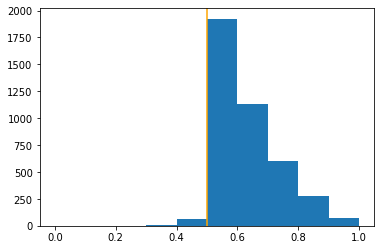

In [89]:
# plot y_hat distribution
plt.hist(y_hat, range=[0, 1])
_ = plt.axvline(x=0.5, color='orange')

In [90]:
# print AUC
"{:0.2f}".format(roc_auc_score(y_val, y_hat)*100.0)

'63.48'

Per the histogram it appears our classifier is more or less predicting every pass will be completed and it does not have strong opinions about many plays. Let's tweak some hyperparameters to see if we can have some improvements.

In [91]:
# set hyperparameters
opt = Adam(learning_rate=.001)
batch_size = 64
epochs = 50

# save model at highest validation accuracy
checkpoint_filepath = 'drive/MyDrive/BDB_2021/'
model_checkpoint_filepath = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [92]:
# compile model, binary crossentropy for our binary classification problem with adam optimizer and accuracy metrics
model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [93]:
# fit model, increasing learning rate and batch size to 64
model1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val), callbacks=[model_checkpoint_filepath, es])

Epoch 1/50
319/319 [==============================] - 3s 8ms/step - loss: 0.6168 - accuracy: 0.6655 - val_loss: 0.6109 - val_accuracy: 0.6696
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 2/50
319/319 [==============================] - 2s 8ms/step - loss: 0.6141 - accuracy: 0.6670 - val_loss: 0.6073 - val_accuracy: 0.6699
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 3/50
319/319 [==============================] - 3s 9ms/step - loss: 0.6121 - accuracy: 0.6668 - val_loss: 0.6084 - val_accuracy: 0.6694
Epoch 4/50
319/319 [==============================] - 2s 8ms/step - loss: 0.6092 - accuracy: 0.6674 - val_loss: 0.6108 - val_accuracy: 0.6686
Epoch 5/50
319/319 [==============================] - 3s 8ms/step - loss: 0.6078 - accuracy: 0.6697 - val_loss: 0.6080 - val_accuracy: 0.6699
Epoch 6/50
319/319 [==============================] - 3s 8ms/step - loss: 0.6069 - accuracy: 0.6683 - val_loss: 0.6107 - val_accuracy: 0.6676
Epoch 7/50
319/319

Still not much learning happening over epochs with the increased learning rate and larger batch size.

In [94]:
model1.load_weights(checkpoint_filepath)
y_hat = model1.predict(X_val)

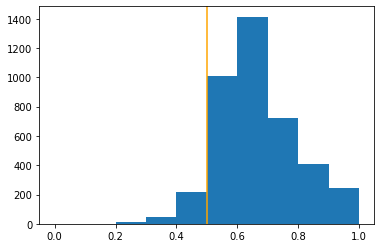

In [95]:
plt.hist(y_hat, range=[0, 1])
_ = plt.axvline(x=0.5, color='orange')

In [96]:
"{:0.2f}".format(roc_auc_score(y_val, y_hat)*100.0)

'63.16'

With these hyperparameters the classifier is predicting some more passes to be incomplete and has a stronger opinion as the y_hats are a little more widely distributed than the first run.

Let's increase learning rate up to .01 and increase batch size to 128.

In [97]:
# update learning rate to .01
opt = Adam(learning_rate=.01)

In [98]:
# compile model, binary crossentropy for our binary classification problem with adam optimizer and accuracy metrics
model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [99]:
EPOCHS = 50
checkpoint_filepath = 'drive/MyDrive/BDB_2021/'
model_checkpoint_filepath = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [100]:
# fit model, increasing batch size to 128
model1.fit(X_train, y_train, batch_size=128, epochs=EPOCHS, verbose=1, validation_data=(X_val, y_val), callbacks=[model_checkpoint_filepath, es])

Epoch 1/50
160/160 [==============================] - 2s 11ms/step - loss: 0.6297 - accuracy: 0.6652 - val_loss: 0.6212 - val_accuracy: 0.6738
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 2/50
160/160 [==============================] - 2s 11ms/step - loss: 0.6256 - accuracy: 0.6655 - val_loss: 0.6236 - val_accuracy: 0.6691
Epoch 3/50
160/160 [==============================] - 2s 11ms/step - loss: 0.6236 - accuracy: 0.6656 - val_loss: 0.6205 - val_accuracy: 0.6691
Epoch 4/50
160/160 [==============================] - 2s 11ms/step - loss: 0.6376 - accuracy: 0.6665 - val_loss: 0.6349 - val_accuracy: 0.6691
Epoch 5/50
160/160 [==============================] - 2s 11ms/step - loss: 0.6371 - accuracy: 0.6665 - val_loss: 0.6349 - val_accuracy: 0.6691
Epoch 6/50
160/160 [==============================] - 2s 11ms/step - loss: 0.6369 - accuracy: 0.6665 - val_loss: 0.6348 - val_accuracy: 0.6691
Epoch 7/50
160/160 [==============================] - 2s 11ms/step - loss: 0.

Zero learning happening over epochs with the increased learning rate and larger batch size.

In [101]:
model1.load_weights(checkpoint_filepath)
y_hat = model1.predict(X_val)

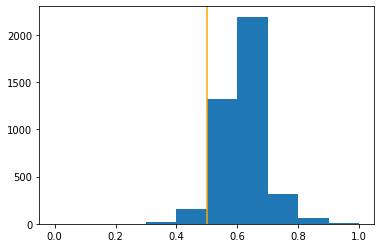

In [102]:
plt.hist(y_hat, range=[0, 1])
_ = plt.axvline(x=0.5, color='orange')

In [103]:
"{:0.2f}".format(roc_auc_score(y_val, y_hat)*100.0)

'62.10'

With these hyperparameters the classifier back to predicting almost everything being a completed pass. 

Try again with a smaller learning rate than the original run and larger batch size.

In [104]:
# update learning rate to .0005
opt = Adam(learning_rate=.0005)

In [105]:
# compile model, binary crossentropy for our binary classification problem with adam optimizer and accuracy metrics
model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [106]:
EPOCHS = 50
checkpoint_filepath = 'drive/MyDrive/BDB_2021/'
model_checkpoint_filepath = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [107]:
# fit model, increasing batch size to 512
model1.fit(X_train, y_train, batch_size=512, epochs=EPOCHS, verbose=1, validation_data=(X_val, y_val), callbacks=[model_checkpoint_filepath, es])

Epoch 1/50
40/40 [==============================] - 2s 36ms/step - loss: 0.6161 - accuracy: 0.6671 - val_loss: 0.6104 - val_accuracy: 0.6716
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 2/50
40/40 [==============================] - 1s 24ms/step - loss: 0.6131 - accuracy: 0.6671 - val_loss: 0.6093 - val_accuracy: 0.6721
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 3/50
40/40 [==============================] - 1s 25ms/step - loss: 0.6102 - accuracy: 0.6664 - val_loss: 0.6085 - val_accuracy: 0.6735
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 4/50
40/40 [==============================] - 1s 25ms/step - loss: 0.6099 - accuracy: 0.6685 - val_loss: 0.6077 - val_accuracy: 0.6726
Epoch 5/50
40/40 [==============================] - 1s 25ms/step - loss: 0.6079 - accuracy: 0.6685 - val_loss: 0.6073 - val_accuracy: 0.6726
Epoch 6/50
40/40 [==============================] - 1s 25ms/step - loss: 0.6058 - accuracy: 0.6691 -

In [108]:
model1.load_weights(checkpoint_filepath)
y_hat = model1.predict(X_val)

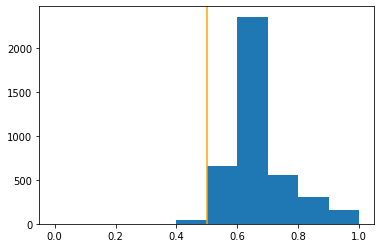

In [109]:
plt.hist(y_hat, range=[0, 1])
_ = plt.axvline(x=0.5, color='orange')

In [110]:
"{:0.2f}".format(roc_auc_score(y_val, y_hat)*100.0)

'63.13'

Still nothing good happening. Let's see what happens when we tweak the architecture to add some more filters, more layers, switch to average pooling, and reduce dropout since overfitting doesn't appear to be an issue.

In [111]:
# initialize sequential model
model1 = Sequential()

# first convolutional layer;
model1.add(Conv2D(128, kernel_size=(1,1), activation='relu', input_shape=(6,7,10)))
model1.add(Conv2D(64, kernel_size=(1,1), activation='relu'))

# second convolutional layer; 
model1.add(Conv2D(128, kernel_size=(1,1), activation='relu'))
model1.add(Conv2D(64, kernel_size=(1,1), activation='relu'))
model1.add(AvgPool2D(pool_size=(1,6))) # try 1,6?
model1.add(Dropout(0.20))
model1.add(Flatten())

# dense hidden layer; with dropout
model1.add(Dense(128, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.20))

# output layer; 1 neuron with sigmoid activation for binary classification
model1.add(Dense(1, activation='sigmoid')) 

In [112]:
# show model summary
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 6, 7, 128)         1408      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 7, 64)          8256      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 7, 128)         8320      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 7, 64)          8256      
_________________________________________________________________
average_pooling2d (AveragePo (None, 6, 1, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 1, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 384)              

In [113]:
es = EarlyStopping(monitor='val_accuracy', mode='max', restore_best_weights=True, verbose=1, patience=10)
opt = Adam(learning_rate=.001)

In [114]:
# compile model, binary crossentropy for our binary classification problem with adam optimizer and accuracy metrics
model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [115]:
EPOCHS = 50
checkpoint_filepath = 'drive/MyDrive/BDB_2021/'
model_checkpoint_filepath = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [116]:
# fit model
model1.fit(X_train, y_train, batch_size=256, epochs=EPOCHS, verbose=1, validation_data=(X_val, y_val), callbacks=[model_checkpoint_filepath, es])

Epoch 1/50
80/80 [==============================] - 4s 46ms/step - loss: 0.6409 - accuracy: 0.6586 - val_loss: 0.6181 - val_accuracy: 0.6706
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 2/50
80/80 [==============================] - 3s 43ms/step - loss: 0.6168 - accuracy: 0.6654 - val_loss: 0.6075 - val_accuracy: 0.6696
Epoch 3/50
80/80 [==============================] - 4s 45ms/step - loss: 0.6144 - accuracy: 0.6662 - val_loss: 0.6058 - val_accuracy: 0.6726
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 4/50
80/80 [==============================] - 4s 45ms/step - loss: 0.6120 - accuracy: 0.6660 - val_loss: 0.6082 - val_accuracy: 0.6735
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 5/50
80/80 [==============================] - 4s 45ms/step - loss: 0.6068 - accuracy: 0.6705 - val_loss: 0.6046 - val_accuracy: 0.6723
Epoch 6/50
80/80 [==============================] - 4s 46ms/step - loss: 0.6055 - accuracy: 0.6714 -

In [117]:
model1.load_weights(checkpoint_filepath)
y_hat = model1.predict(X_val)

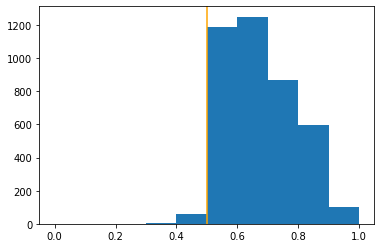

In [118]:
plt.hist(y_hat, range=[0, 1])
_ = plt.axvline(x=0.5, color='orange')

In [119]:
"{:0.2f}".format(roc_auc_score(y_val, y_hat)*100.0)

'63.21'

Still no meaningful improvement. Let's move on from this architecture.

### Model 2
Let's see if an architecture with more parameters and a block approach like AlexNet has better success.

We'll have a sequential model where:


1.   The first convolutional block takes in the 6x7 image, has 96 filters, max pooling, and batch normalization.
2.   The second covolutional block receives the 6x7x96 activation map from the first convolutional layer and is much deeper with 256 kernels. Max-pooling with pool size of 2 and stride of 2 reduces the data flowing through the network to 3x3 and apply batch normalization
3. The third block is deeper with 3 convolutional layers and applies max pooling and batch normalization.
3.   The dense block receives flattened info to map features into class of images as completed pass or not completed pass. Receives extracted features as input instead of pixels. Dropout is intentionally forgetting 50% of the neurons after two layers to reduce risk of overfitting.
4. The output layer consists of one neuron with the sigmoid activation function for our binary classification problem.

In [120]:
# initialize sequential model
model2 = Sequential()

# first convolutional block; takes in the 6 x 7 image with 96 filters, 1x1 kernel size, default padding and stride
model2.add(Conv2D(96, kernel_size=(1,1), activation='relu', input_shape=(6,7,10)))
model2.add(MaxPooling2D(pool_size=(2,2))) # 1,6 make better sense to learn per offensive player?
model2.add(BatchNormalization())

# second convolutional block;
model2.add(Conv2D(256, kernel_size=(1,1), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(BatchNormalization())

# third convolutional block;
model2.add(Conv2D(256, kernel_size=(1,1), activation='relu'))
model2.add(Conv2D(384, kernel_size=(1,1), activation='relu'))
model2.add(Conv2D(384, kernel_size=(1,1), activation='relu'))
model2.add(MaxPooling2D(pool_size=(1,1)))
model2.add(BatchNormalization())

# dense layers
model2.add(Flatten())
model2.add(Dense(4096, activation='tanh'))
model2.add(Dropout(0.5))
model2.add(Dense(4096, activation='tanh'))
model2.add(Dropout(0.5))

# output layer; 1 neuron with sigmoid activation for binary classification
model2.add(Dense(1, activation='sigmoid')) 

In [121]:
# show model summary
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 6, 7, 96)          1056      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 96)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 3, 96)          384       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 3, 3, 256)         24832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 256)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 1, 256)         1024      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 1, 256)        

In [122]:
# set hyperparameters
opt = Adam(learning_rate=.001)
batch_size = 64
epochs = 50

# save model at highest validation accuracy
checkpoint_filepath = 'drive/MyDrive/BDB_2021/'
model_checkpoint_filepath = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [123]:
# compile model, binary crossentropy for our binary classification problem with adam optimizer and accuracy metrics
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [124]:
# fit model
model2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val), callbacks=[model_checkpoint_filepath, es])

Epoch 1/50
319/319 [==============================] - 49s 152ms/step - loss: 0.8680 - accuracy: 0.6054 - val_loss: 0.7487 - val_accuracy: 0.5623
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 2/50
319/319 [==============================] - 52s 162ms/step - loss: 0.6833 - accuracy: 0.6253 - val_loss: 0.6637 - val_accuracy: 0.6136
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 3/50
319/319 [==============================] - 49s 154ms/step - loss: 0.6898 - accuracy: 0.6205 - val_loss: 0.6726 - val_accuracy: 0.6185
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 4/50
319/319 [==============================] - 49s 155ms/step - loss: 0.6944 - accuracy: 0.6189 - val_loss: 0.6668 - val_accuracy: 0.6283
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 5/50
319/319 [==============================] - 49s 154ms/step - loss: 0.6860 - accuracy: 0.6219 - val_loss: 0.7291 - val_accuracy: 0.5554
Epoch 6/50
319/

In [125]:
model2.load_weights(checkpoint_filepath)
y_hat = model2.predict(X_val)

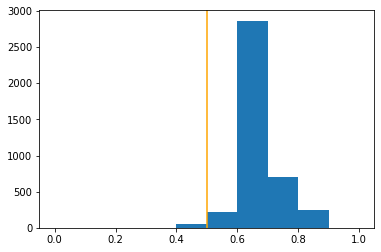

In [126]:
plt.hist(y_hat, range=[0, 1])
_ = plt.axvline(x=0.5, color='orange')

In [127]:
"{:0.2f}".format(roc_auc_score(y_val, y_hat)*100.0)

'51.08'

Well unfortunately this architecture is not working either.

### Model 3
Let's try and go deeper with something inspired by VGGNet. 
We'll have a sequential model where:


1.   The first convolutional block takes in the 7x6 image, applies max pooling and batch normalization.
2.   The second convolutional block receives the 7x6x64 activation map from the first convolutional block, is wider with twice as many neurons, and applies max-pooling and batch normalization. 
3. The third convolutional block goes even wider and deeper before applying max pooling and batch normalization.
4.   The fourth and fifth blocks are even wider yet with 512 filters before max pooling and batch normalization are applied.
5. Again the information is flattened before being fed into a dense layer with 4096 neurons and again the output layer consists of one neuron with the sigmoid activation function for our binary classification problem.

37 million parameters!

In [128]:
# initialize sequential model
model3 = Sequential()

# first convolutional block; 
model3.add(Conv2D(64, kernel_size=(1,1), activation='relu', input_shape=(6,7,10)))
model3.add(Conv2D(64, kernel_size=(1,1), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(BatchNormalization())

# second convolutional block;
model3.add(Conv2D(128, kernel_size=(1,1), activation='relu'))
model3.add(Conv2D(128, kernel_size=(1,1), activation='relu'))
model3.add(MaxPooling2D(pool_size=(1,1)))
model3.add(BatchNormalization())

# third convolutional block;
model3.add(Conv2D(256, kernel_size=(1,1), activation='relu'))
model3.add(Conv2D(256, kernel_size=(1,1), activation='relu'))
model3.add(Conv2D(256, kernel_size=(1,1), activation='relu'))
model3.add(MaxPooling2D(pool_size=(1,1)))
model3.add(BatchNormalization())

# fourth convolutional block;
model3.add(Conv2D(512, kernel_size=(1,1), activation='relu'))
model3.add(Conv2D(512, kernel_size=(1,1), activation='relu'))
model3.add(Conv2D(512, kernel_size=(1,1), activation='relu'))
model3.add(MaxPooling2D(pool_size=(1,1)))
model3.add(BatchNormalization())

# fifth convolutional block;
model3.add(Conv2D(512, kernel_size=(1,1), activation='relu'))
model3.add(Conv2D(512, kernel_size=(1,1), activation='relu'))
model3.add(Conv2D(512, kernel_size=(1,1), activation='relu'))
model3.add(MaxPooling2D(pool_size=(1,1)))
model3.add(BatchNormalization())

# dense layers
model3.add(Flatten())
model3.add(Dense(4096, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(4096, activation='relu'))
model3.add(Dropout(0.5))

# output layer; 1 neuron with sigmoid activation for binary classification
model3.add(Dense(1, activation='sigmoid')) 

In [129]:
# show model summary
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 6, 7, 64)          704       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 6, 7, 64)          4160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 3, 3, 64)          256       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 3, 128)         8320      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 3, 128)         16512     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 128)        

In [130]:
# set hyperparameters
opt = Adam(learning_rate=.0005)
batch_size = 64
epochs = 50

# save model at highest validation accuracy
checkpoint_filepath = 'drive/MyDrive/BDB_2021/'
model_checkpoint_filepath = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [131]:
# compile model, binary crossentropy for our binary classification problem with adam optimizer and accuracy metrics
model3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [132]:
# fit model
model3.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val), callbacks=[model_checkpoint_filepath, es])

Epoch 1/50
319/319 [==============================] - 156s 485ms/step - loss: 0.7449 - accuracy: 0.6380 - val_loss: 0.6246 - val_accuracy: 0.6691
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 2/50
319/319 [==============================] - 156s 489ms/step - loss: 0.6252 - accuracy: 0.6629 - val_loss: 0.6229 - val_accuracy: 0.6654
Epoch 3/50
319/319 [==============================] - 160s 503ms/step - loss: 0.6136 - accuracy: 0.6666 - val_loss: 0.6445 - val_accuracy: 0.6701
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 4/50
319/319 [==============================] - 158s 495ms/step - loss: 0.6086 - accuracy: 0.6684 - val_loss: 0.6545 - val_accuracy: 0.6627
Epoch 5/50
319/319 [==============================] - 158s 495ms/step - loss: 0.6040 - accuracy: 0.6719 - val_loss: 0.6316 - val_accuracy: 0.6654
Epoch 6/50
319/319 [==============================] - 156s 490ms/step - loss: 0.6002 - accuracy: 0.6743 - val_loss: 0.6375 - val_accuracy: 0

In [133]:
model3.load_weights(checkpoint_filepath)
y_hat = model3.predict(X_val)

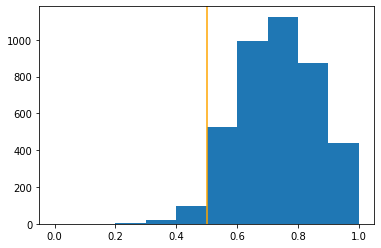

In [134]:
plt.hist(y_hat, range=[0, 1])
_ = plt.axvline(x=0.5, color='orange')

In [135]:
"{:0.2f}".format(roc_auc_score(y_val, y_hat)*100.0)

'60.19'

Bummer, going deeper doesn't help! This architecture is starting the learn the training accuracy but not showing any improvement in validation accuracy.

### Model 4
The 2020 Big Data Bowl winner used a functional model to accurately predict how many rushing yards would be gained on a given play. This model is loosely based on that architecture. The authors of that model had success using multiple layers while using a weighted sum of average and max pooling. If I am reading their comments right it sounds like pooled to size (1,10) to learn per offensive player. They had 10 offensive players in their data so I will try to pool (1,6) here. 


1.   The first convolutional block takes in the 7x6 image and applies a weighted average of 30% max pooling and 70% average pooling.
2.   The second covolutional block and applies some batch normalization with 30% max pooling and 70% average pooling again.
3.   The third hidden layer is a dense layer used to map features into class of images as completed pass or not completed pass. Overfitting hasn't really been an issue for me yet so we'll try minimal dropout of 20% before the output layer.
4. The output layer consists of one neuron with the sigmoid activation function for our binary classification problem.

In [136]:
inputdense_players = Input(shape=(6,7,10), name = 'player_feats_input')

# first convolutional block; takes in the 6 x 7 image with 96 filters, 1x1 kernel size, default padding and stride
model4 = Conv2D(128, kernel_size=(1,1), strides=(1,1), activation='relu')(inputdense_players)
model4 = Conv2D(160, kernel_size=(1,1), strides=(1,1), activation='relu')(model4)
model4 = Conv2D(128, kernel_size=(1,1), strides=(1,1), activation='relu')(model4)

# Try weighted sum of of max and average pooling
model4max = MaxPooling2D(pool_size=(1,6))(model4)
model4max = Lambda(lambda x1 : x1*0.3)(model4max)
model4avg = AvgPool2D(pool_size=(1,6))(model4)
model4avg = Lambda(lambda x1 : x1*0.7)(model4avg)

model4 = Add()([model4max, model4avg])
model4 = Lambda(lambda y : K.squeeze(y,2))(model4)
model4 = BatchNormalization()(model4)

# second convolutional block;
model4 = Conv1D(160, kernel_size=1, strides=1, activation='relu')(model4)
model4 = BatchNormalization()(model4)
model4 = Conv1D(96, kernel_size=1, strides=1, activation='relu')(model4)
model4 = BatchNormalization()(model4)
model4 = Conv1D(96, kernel_size=1, strides=1, activation='relu')(model4)
model4 = BatchNormalization()(model4)

# more pooling
model4max = MaxPooling1D(pool_size=6)(model4)
model4max = Lambda(lambda x1 : x1*0.3)(model4max)
model4avg = AvgPool1D(pool_size=6)(model4)
model4avg = Lambda(lambda x1 : x1*0.7)(model4avg)

model4 = Add()([model4max, model4avg])
model4 = Lambda(lambda y : K.squeeze(y,1))(model4)

# dense layers
model4 = Dense(96, activation='relu')(model4)
model4 = BatchNormalization()(model4)
model4 = Dense(256, activation='relu')(model4)
model4 = LayerNormalization()(model4)
model4 = Dropout(0.3)(model4)

# output layer; 1 neuron with sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(model4)

model4 = Model(inputs = [inputdense_players], outputs = predictions)

In [137]:
# show model summary
model4.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
player_feats_input (InputLayer) [(None, 6, 7, 10)]   0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 6, 7, 128)    1408        player_feats_input[0][0]         
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 6, 7, 160)    20640       conv2d_24[0][0]                  
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 6, 7, 128)    20608       conv2d_25[0][0]                  
______________________________________________________________________________________________

In [138]:
# set hyperparameters
opt = Adam(learning_rate=.001)
batch_size = 64
epochs = 50

# save model at highest validation accuracy
checkpoint_filepath = 'drive/MyDrive/BDB_2021/'
model_checkpoint_filepath = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [139]:
# compile model, binary crossentropy for our binary classification problem with adam optimizer and accuracy metrics
model4.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [140]:
# fit model
model4.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val), callbacks=[model_checkpoint_filepath, es])

Epoch 1/50
319/319 [==============================] - 11s 28ms/step - loss: 0.6777 - accuracy: 0.6304 - val_loss: 0.6195 - val_accuracy: 0.6689


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 2/50
319/319 [==============================] - 9s 27ms/step - loss: 0.6244 - accuracy: 0.6591 - val_loss: 0.6157 - val_accuracy: 0.6679
Epoch 3/50
319/319 [==============================] - 9s 27ms/step - loss: 0.6127 - accuracy: 0.6665 - val_loss: 0.6074 - val_accuracy: 0.6684
Epoch 4/50
319/319 [==============================] - 9s 27ms/step - loss: 0.6086 - accuracy: 0.6665 - val_loss: 0.6061 - val_accuracy: 0.6691
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/50
319/319 [==============================] - 9s 27ms/step - loss: 0.6085 - accuracy: 0.6661 - val_loss: 0.6084 - val_accuracy: 0.6649
Epoch 6/50
319/319 [==============================] - 9s 27ms/step - loss: 0.6036 - accuracy: 0.6723 - val_loss: 0.6160 - val_accuracy: 0.6465
Epoch 7/50
319/319 [==============================] - 9s 27ms/step - loss: 0.6027 - accuracy: 0.6714 - val_loss: 0.6084 - val_accuracy: 0.6637
Epoch 8/50
319/319 [==============================] - 9s 27ms/step - loss: 0.5999 - accuracy: 0.6748 - val_loss: 0.6049 - val_accuracy: 0.6772
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/50
319/319 [==============================] - 9s 27ms/step - loss: 0.5997 - accuracy: 0.6737 - val_loss: 0.6029 - val_accuracy: 0.6758
Epoch 10/50
319/319 [==============================] - 9s 27ms/step - loss: 0.5968 - accuracy: 0.6770 - val_loss: 0.6021 - val_accuracy: 0.6797
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/50
319/319 [==============================] - 9s 27ms/step - loss: 0.5965 - accuracy: 0.6763 - val_loss: 0.6061 - val_accuracy: 0.6760
Epoch 12/50
319/319 [==============================] - 9s 27ms/step - loss: 0.5991 - accuracy: 0.6765 - val_loss: 0.6049 - val_accuracy: 0.6755
Epoch 13/50
319/319 [==============================] - 9s 27ms/step - loss: 0.5950 - accuracy: 0.6762 - val_loss: 0.6056 - val_accuracy: 0.6706
Epoch 14/50
319/319 [==============================] - 9s 27ms/step - loss: 0.5934 - accuracy: 0.6785 - val_loss: 0.6125 - val_accuracy: 0.6728
Epoch 15/50
319/319 [==============================] - 9s 27ms/step - loss: 0.5915 - accuracy: 0.6826 - val_loss: 0.6137 - val_accuracy: 0.6684
Epoch 16/50
319/319 [==============================] - 9s 27ms/step - loss: 0.5872 - accuracy: 0.6822 - val_loss: 0.6075 - val_accuracy: 0.6804


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 17/50
319/319 [==============================] - 9s 27ms/step - loss: 0.5843 - accuracy: 0.6879 - val_loss: 0.6070 - val_accuracy: 0.6632
Epoch 18/50
319/319 [==============================] - 9s 28ms/step - loss: 0.5859 - accuracy: 0.6888 - val_loss: 0.6033 - val_accuracy: 0.6782
Epoch 19/50
319/319 [==============================] - 9s 28ms/step - loss: 0.5785 - accuracy: 0.6954 - val_loss: 0.6213 - val_accuracy: 0.6576
Epoch 20/50
319/319 [==============================] - 9s 27ms/step - loss: 0.5776 - accuracy: 0.6930 - val_loss: 0.6096 - val_accuracy: 0.6767
Epoch 21/50
319/319 [==============================] - 9s 27ms/step - loss: 0.5718 - accuracy: 0.6967 - val_loss: 0.6238 - val_accuracy: 0.6401
Epoch 22/50
319/319 [==============================] - 9s 27ms/step - loss: 0.5706 - accuracy: 0.6992 - val_loss: 0.6061 - val_accuracy: 0.6551
Epoch 23/50
319/319 [==============================] - 9s 28ms/step - l

In [141]:
model4.load_weights(checkpoint_filepath)
y_hat = model4.predict(X_val)

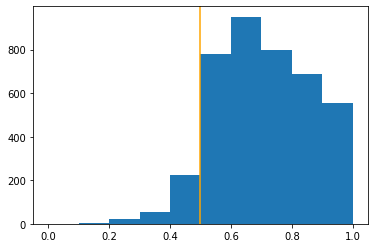

In [142]:
plt.hist(y_hat, range=[0, 1])
_ = plt.axvline(x=0.5, color='orange')

In [143]:
"{:0.2f}".format(roc_auc_score(y_val, y_hat)*100.0)

'65.45'

Technically this is the best model. We are predicting some plays to have a low expected completion percentage but still not much more accurate than projecting everything to be complete. 

Let's tweak the pooling to be 50/50 max/avg, pool size to be (1,7) to attempt to learn defensive players, and decrease the learning rate.

In [144]:
inputdense_players = Input(shape=(6,7,10), name = 'player_feats_input')

# first convolutional block; takes in the 6 x 7 image with 96 filters, 1x1 kernel size, default padding and stride
model4 = Conv2D(128, kernel_size=(1,1), strides=(1,1), activation='relu')(inputdense_players)
model4 = Conv2D(160, kernel_size=(1,1), strides=(1,1), activation='relu')(model4)
model4 = Conv2D(128, kernel_size=(1,1), strides=(1,1), activation='relu')(model4)

# Try weighted sum of of max and average pooling
model4max = MaxPooling2D(pool_size=(1,7))(model4)
model4max = Lambda(lambda x1 : x1*0.5)(model4max)
model4avg = AvgPool2D(pool_size=(1,7))(model4)
model4avg = Lambda(lambda x1 : x1*0.5)(model4avg)

model4 = Add()([model4max, model4avg])
model4 = Lambda(lambda y : K.squeeze(y,2))(model4)
model4 = BatchNormalization()(model4)

# second convolutional block;
model4 = Conv1D(160, kernel_size=1, strides=1, activation='relu')(model4)
model4 = BatchNormalization()(model4)
model4 = Conv1D(96, kernel_size=1, strides=1, activation='relu')(model4)
model4 = BatchNormalization()(model4)
model4 = Conv1D(96, kernel_size=1, strides=1, activation='relu')(model4)
model4 = BatchNormalization()(model4)

# more pooling
model4max = MaxPooling1D(pool_size=6)(model4)
model4max = Lambda(lambda x1 : x1*0.5)(model4max)
model4avg = AvgPool1D(pool_size=6)(model4)
model4avg = Lambda(lambda x1 : x1*0.5)(model4avg)

model4 = Add()([model4max, model4avg])
model4 = Lambda(lambda y : K.squeeze(y,1))(model4)

# dense layers
model4 = Dense(96, activation='relu')(model4)
model4 = BatchNormalization()(model4)
model4 = Dense(256, activation='relu')(model4)
model4 = LayerNormalization()(model4)
model4 = Dropout(0.2)(model4)

# output layer; 1 neuron with sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(model4)

model4 = Model(inputs = [inputdense_players], outputs = predictions)

In [145]:
# set hyperparameters
opt = Adam(learning_rate=.00075)
batch_size = 64
epochs = 50

# save model at highest validation accuracy
checkpoint_filepath = 'drive/MyDrive/BDB_2021/'
model_checkpoint_filepath = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [146]:
# compile model, binary crossentropy for our binary classification problem with adam optimizer and accuracy metrics
model4.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [147]:
# fit model
model4.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val), callbacks=[model_checkpoint_filepath, es])

Epoch 1/50
319/319 [==============================] - 12s 30ms/step - loss: 0.6751 - accuracy: 0.6308 - val_loss: 0.6203 - val_accuracy: 0.6463
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
319/319 [==============================] - 9s 28ms/step - loss: 0.6217 - accuracy: 0.6596 - val_loss: 0.6199 - val_accuracy: 0.6681
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/50
319/319 [==============================] - 9s 28ms/step - loss: 0.6123 - accuracy: 0.6640 - val_loss: 0.6125 - val_accuracy: 0.6704
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/50
319/319 [==============================] - 9s 27ms/step - loss: 0.6057 - accuracy: 0.6655 - val_loss: 0.6081 - val_accuracy: 0.6738
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/50
319/319 [==============================] - 9s 28ms/step - loss: 0.6028 - accuracy: 0.6716 - val_loss: 0.6095 - val_accuracy: 0.6605
Epoch 6/50
319/319 [==============================] - 9s 28ms/step - loss: 0.6004 - accuracy: 0.6736 - val_loss: 0.6085 - val_accuracy: 0.6554
Epoch 7/50
319/319 [==============================] - 9s 27ms/step - loss: 0.5969 - accuracy: 0.6761 - val_loss: 0.6091 - val_accuracy: 0.6743
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/50
319/319 [==============================] - 9s 28ms/step - loss: 0.5961 - accuracy: 0.6791 - val_loss: 0.6253 - val_accuracy: 0.6726
Epoch 9/50
319/319 [==============================] - 9s 28ms/step - loss: 0.6012 - accuracy: 0.6701 - val_loss: 0.6170 - val_accuracy: 0.6392
Epoch 10/50
319/319 [==============================] - 9s 28ms/step - loss: 0.5942 - accuracy: 0.6755 - val_loss: 0.6204 - val_accuracy: 0.6423
Epoch 11/50
319/319 [==============================] - 9s 28ms/step - loss: 0.5937 - accuracy: 0.6780 - val_loss: 0.6029 - val_accuracy: 0.6765
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/50
319/319 [==============================] - 9s 28ms/step - loss: 0.5928 - accuracy: 0.6794 - val_loss: 0.6050 - val_accuracy: 0.6706
Epoch 13/50
319/319 [==============================] - 9s 28ms/step - loss: 0.5874 - accuracy: 0.6827 - val_loss: 0.5953 - val_accuracy: 0.6777
INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/50
319/319 [==============================] - 9s 28ms/step - loss: 0.5841 - accuracy: 0.6891 - val_loss: 0.6016 - val_accuracy: 0.6716
Epoch 15/50
319/319 [==============================] - 9s 28ms/step - loss: 0.5800 - accuracy: 0.6897 - val_loss: 0.6128 - val_accuracy: 0.6595
Epoch 16/50
319/319 [==============================] - 9s 28ms/step - loss: 0.5759 - accuracy: 0.6930 - val_loss: 0.5985 - val_accuracy: 0.6713
Epoch 17/50
319/319 [==============================] - 9s 28ms/step - loss: 0.5711 - accuracy: 0.6980 - val_loss: 0.5971 - val_accuracy: 0.6743
Epoch 18/50
319/319 [==============================] - 9s 28ms/step - loss: 0.5679 - accuracy: 0.7044 - val_loss: 0.6236 - val_accuracy: 0.6426
Epoch 19/50
319/319 [==============================] - 9s 28ms/step - loss: 0.5669 - accuracy: 0.7049 - val_loss: 0.5962 - val_accuracy: 0.6686
Epoch 20/50
319/319 [==============================] - 9s 28ms/step - loss: 0.5627 - accuracy: 0.7045 - val_loss: 0.5994 - val_accuracy:

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 21/50
319/319 [==============================] - 9s 28ms/step - loss: 0.5595 - accuracy: 0.7082 - val_loss: 0.6088 - val_accuracy: 0.6844
Epoch 22/50
319/319 [==============================] - 9s 28ms/step - loss: 0.5527 - accuracy: 0.7137 - val_loss: 0.6069 - val_accuracy: 0.6632
Epoch 23/50
319/319 [==============================] - 9s 28ms/step - loss: 0.5522 - accuracy: 0.7158 - val_loss: 0.6150 - val_accuracy: 0.6745
Epoch 24/50
319/319 [==============================] - 9s 28ms/step - loss: 0.5476 - accuracy: 0.7179 - val_loss: 0.6102 - val_accuracy: 0.6745
Epoch 25/50
319/319 [==============================] - 9s 28ms/step - loss: 0.5460 - accuracy: 0.7209 - val_loss: 0.6060 - val_accuracy: 0.6731
Epoch 26/50
319/319 [==============================] - 9s 28ms/step - loss: 0.5358 - accuracy: 0.7260 - val_loss: 0.6110 - val_accuracy: 0.6794
Epoch 27/50
319/319 [==============================] - 9s 28ms/step - loss: 0.5286 - accuracy: 0.7338 - val_loss: 0.6149 - val_accuracy:

In [148]:
model4.load_weights(checkpoint_filepath)
y_hat = model4.predict(X_val)

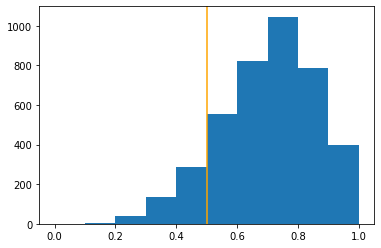

In [149]:
plt.hist(y_hat, range=[0, 1])
_ = plt.axvline(x=0.5, color='orange')

In [150]:
"{:0.2f}".format(roc_auc_score(y_val, y_hat)*100.0)

'66.95'

Best yet (technically). Still seeing predictions clustered around the mean and not developing strong opinions. Let's increase the dropout rate, increase the learning rate, and tweak out mix of max and average pooling again.

In [152]:
inputdense_players = Input(shape=(6,7,10), name = 'player_feats_input')

# first convolutional block; takes in the 6 x 7 image with 96 filters, 1x1 kernel size, default padding and stride
model4 = Conv2D(128, kernel_size=(1,1), strides=(1,1), activation='relu')(inputdense_players)
model4 = Conv2D(160, kernel_size=(1,1), strides=(1,1), activation='relu')(model4)
model4 = Conv2D(128, kernel_size=(1,1), strides=(1,1), activation='relu')(model4)
model4 = Conv2D(128, kernel_size=(1,1), strides=(1,1), activation='relu')(model4)
model4 = Conv2D(128, kernel_size=(1,1), strides=(1,1), activation='relu')(model4)

# Try weighted sum of of max and average pooling
model4max = MaxPooling2D(pool_size=(1,7))(model4)
model4max = Lambda(lambda x1 : x1*0.33)(model4max)
model4avg = AvgPool2D(pool_size=(1,7))(model4)
model4avg = Lambda(lambda x1 : x1*0.67)(model4avg)

model4 = Add()([model4max, model4avg])
model4 = Lambda(lambda y : K.squeeze(y,2))(model4)
model4 = BatchNormalization()(model4)

# second convolutional block;
model4 = Conv1D(160, kernel_size=1, strides=1, activation='relu')(model4)
model4 = BatchNormalization()(model4)
model4 = Conv1D(96, kernel_size=1, strides=1, activation='relu')(model4)
model4 = BatchNormalization()(model4)
model4 = Conv1D(64, kernel_size=1, strides=1, activation='relu')(model4)
model4 = BatchNormalization()(model4)
model4 = Conv1D(32, kernel_size=1, strides=1, activation='relu')(model4)
model4 = BatchNormalization()(model4)
model4 = Conv1D(32, kernel_size=1, strides=1, activation='relu')(model4)
model4 = BatchNormalization()(model4)

# more pooling
model4max = MaxPooling1D(pool_size=6)(model4)
model4max = Lambda(lambda x1 : x1*0.33)(model4max)
model4avg = AvgPool1D(pool_size=6)(model4)
model4avg = Lambda(lambda x1 : x1*0.67)(model4avg)

model4 = Add()([model4max, model4avg])
model4 = Lambda(lambda y : K.squeeze(y,1))(model4)

# dense layers
model4 = Dense(96, activation='relu')(model4)
model4 = BatchNormalization()(model4)
model4 = Dense(256, activation='relu')(model4)
model4 = LayerNormalization()(model4)
model4 = Dense(128, activation='relu')(model4)
model4 = BatchNormalization()(model4)
model4 = Dense(128, activation='relu')(model4)
model4 = LayerNormalization()(model4)
model4 = Dropout(0.3)(model4)

# output layer; 1 neuron with sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(model4)

model4 = Model(inputs = [inputdense_players], outputs = predictions)

In [153]:
# show model summary
model4.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
player_feats_input (InputLayer) [(None, 6, 7, 10)]   0                                            
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 6, 7, 128)    1408        player_feats_input[0][0]         
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 6, 7, 160)    20640       conv2d_35[0][0]                  
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 6, 7, 128)    20608       conv2d_36[0][0]                  
____________________________________________________________________________________________

In [156]:
# set hyperparameters
opt = Adam(learning_rate=.0015)
batch_size = 128
epochs = 50

# save model at highest validation accuracy
checkpoint_filepath = 'drive/MyDrive/BDB_2021/'
model_checkpoint_filepath = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [157]:
# compile model, binary crossentropy for our binary classification problem with adam optimizer and accuracy metrics
model4.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [158]:
# fit model
model4.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val), callbacks=[model_checkpoint_filepath, es])

Epoch 1/50
160/160 [==============================] - 14s 72ms/step - loss: 0.6929 - accuracy: 0.6254 - val_loss: 0.6485 - val_accuracy: 0.6598


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 2/50
160/160 [==============================] - 11s 72ms/step - loss: 0.6254 - accuracy: 0.6596 - val_loss: 0.6221 - val_accuracy: 0.6625


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 3/50
160/160 [==============================] - 12s 72ms/step - loss: 0.6126 - accuracy: 0.6640 - val_loss: 0.6125 - val_accuracy: 0.6704


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 4/50
160/160 [==============================] - 12s 72ms/step - loss: 0.6093 - accuracy: 0.6652 - val_loss: 0.6187 - val_accuracy: 0.6455
Epoch 5/50
160/160 [==============================] - 11s 71ms/step - loss: 0.6150 - accuracy: 0.6634 - val_loss: 0.6123 - val_accuracy: 0.6711


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 6/50
160/160 [==============================] - 11s 72ms/step - loss: 0.6098 - accuracy: 0.6658 - val_loss: 0.6072 - val_accuracy: 0.6681
Epoch 7/50
160/160 [==============================] - 11s 72ms/step - loss: 0.6074 - accuracy: 0.6673 - val_loss: 0.6066 - val_accuracy: 0.6711
Epoch 8/50
160/160 [==============================] - 11s 72ms/step - loss: 0.6075 - accuracy: 0.6661 - val_loss: 0.6107 - val_accuracy: 0.6615
Epoch 9/50
160/160 [==============================] - 11s 72ms/step - loss: 0.6041 - accuracy: 0.6670 - val_loss: 0.6060 - val_accuracy: 0.6694
Epoch 10/50
160/160 [==============================] - 12s 72ms/step - loss: 0.6046 - accuracy: 0.6682 - val_loss: 0.6069 - val_accuracy: 0.6723


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 11/50
160/160 [==============================] - 12s 73ms/step - loss: 0.6023 - accuracy: 0.6691 - val_loss: 0.6066 - val_accuracy: 0.6711
Epoch 12/50
160/160 [==============================] - 12s 74ms/step - loss: 0.5987 - accuracy: 0.6698 - val_loss: 0.6073 - val_accuracy: 0.6625
Epoch 13/50
160/160 [==============================] - 12s 76ms/step - loss: 0.6015 - accuracy: 0.6733 - val_loss: 0.6063 - val_accuracy: 0.6740


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/BDB_2021/assets
Epoch 14/50
160/160 [==============================] - 11s 71ms/step - loss: 0.6126 - accuracy: 0.6671 - val_loss: 0.6086 - val_accuracy: 0.6711
Epoch 15/50
160/160 [==============================] - 12s 74ms/step - loss: 0.6056 - accuracy: 0.6689 - val_loss: 0.6150 - val_accuracy: 0.6691
Epoch 16/50
160/160 [==============================] - 12s 72ms/step - loss: 0.6017 - accuracy: 0.6702 - val_loss: 0.6090 - val_accuracy: 0.6718
Epoch 17/50
160/160 [==============================] - 12s 72ms/step - loss: 0.6050 - accuracy: 0.6690 - val_loss: 0.6153 - val_accuracy: 0.6549
Epoch 18/50
160/160 [==============================] - 12s 73ms/step - loss: 0.6008 - accuracy: 0.6709 - val_loss: 0.6276 - val_accuracy: 0.6625
Epoch 19/50
160/160 [==============================] - 12s 73ms/step - loss: 0.5979 - accuracy: 0.6742 - val_loss: 0.6110 - val_accuracy: 0.6679
Epoch 20/50
160/160 [==============================] - 12s 72ms/s

In [159]:
model4.load_weights(checkpoint_filepath)
y_hat = model4.predict(X_val)

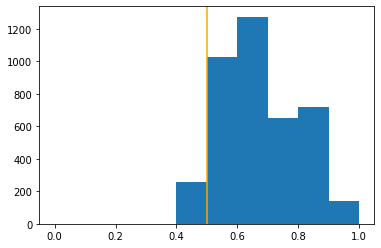

In [160]:
plt.hist(y_hat, range=[0, 1])
_ = plt.axvline(x=0.5, color='orange')

In [161]:
"{:0.2f}".format(roc_auc_score(y_val, y_hat)*100.0)

'64.09'

# Conclusion
I'm disappointed we weren't able to construct something that wasn't really any better than predicting the majority class. I was (am) worried that something was wrong with my preprocessing leading to this result. However, I've reviewed those steps countless times and feel farily confident I have created the right high-dimensional matrix to put into the model architecture. 

At the end of the day I did definitely improve my python skills going through the preprocessing steps and got to play around with a lot of different architectures. Very interested to hear your thoughts on why this classifier wasn't very successfull. Hoping you find a simple error to make it better. I did try a combinations of a lot of different features (not shown in this notebook), however, I felt like trying to imitate what was successful in the 2020 Big Data Bowl winner's solution would get me the best results. 